Name   : **Muhammad Arfani Asra**  

SID    : **D121191071**  

Thesis : **Application of Data Mining in Tuberculosis Contact Segmentation Using Clustering Techniques for Targeted Intervention (Yamali TB South Sulawesi Case Study)**

Content: **This section only contain Clustering Area-Based**


# Import Library & Packages

In [1]:
!pip install kneed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import base64
from IPython.display import display


from google.colab import userdata
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from kneed import KneeLocator
from copy import deepcopy

# Function and Utilities

In [3]:
sns.set_theme(style="whitegrid", palette="bright", font_scale=1.1)

In [4]:
# Membuat direktori 'result' jika belum ada
if not os.path.exists('result'):
    os.makedirs('result')

In [5]:
def find_optimal_clusters(data, max_k=10, algorithm='kmeans', scenario=None, save_path=None):
    """
    Mengevaluasi metrik, menandai titik optimal secara otomatis,
    menampilkan tabel rangkuman serta plot, dan opsional menyimpan tabel.
    """
    # ... (Bagian atas kode tetap sama persis, tidak perlu diubah) ...
    scaler = StandardScaler()
    data_numeric = data.select_dtypes(include=np.number)
    data_scaled = scaler.fit_transform(data_numeric)

    metrics = {'Inertia': [], 'Silhouette': [], 'Davies-Bouldin': [],'Calinski-Harabasz': []}
    k_range = range(2, max_k + 1)

    for k in k_range:
        if algorithm == 'kmeans':
            model = KMeans(n_clusters=k, random_state=42, n_init=10)
        elif algorithm == 'bisecting':
            model = BisectingKMeans(n_clusters=k, random_state=42, n_init=10)
        else:
            raise ValueError("Algoritma tidak dikenal. Pilih 'kmeans' atau 'bisecting'.")

        preds = model.fit_predict(data_scaled)

        if algorithm == 'bisecting':
            inertia = 0
            for i in range(len(data_scaled)):
                cluster_idx = preds[i]
                centroid = model.cluster_centers_[cluster_idx]
                inertia += np.sum((data_scaled[i] - centroid)**2)
            metrics['Inertia'].append(inertia)
        else:
            metrics['Inertia'].append(model.inertia_)

        metrics['Silhouette'].append(silhouette_score(data_scaled, preds))
        metrics['Davies-Bouldin'].append(davies_bouldin_score(data_scaled, preds))
        metrics['Calinski-Harabasz'].append(calinski_harabasz_score(data_scaled, preds))

    metrics_df = pd.DataFrame(metrics, index=k_range)
    metrics_df.index.name = 'k'

    # --- Menemukan dan Menyorot Nilai Optimal di Tabel ---
    print(f"--- Rangkuman Metrik Evaluasi untuk Algoritma: {algorithm.upper()} ---")

    def highlight_top3(s):
        is_top3 = s.isin(s.nlargest(3))
        return ['background-color: lightgreen' if v else '' for v in is_top3]

    def highlight_bottom3(s):
        is_bottom3 = s.isin(s.nsmallest(3))
        return ['background-color: lightcoral' if v else '' for v in is_bottom3]

    # ========== PERUBAHAN STYLING ADA DI SINI ==========
    # Menerapkan styling gabungan: gradasi warna DAN sorotan 3 terbaik
    styled_metrics_df = metrics_df.style \
        .background_gradient(subset=['Inertia', 'Davies-Bouldin'], cmap='Reds_r') \
        .background_gradient(subset=['Silhouette', 'Calinski-Harabasz'], cmap='Greens') \
        .apply(highlight_bottom3, subset=['Inertia', 'Davies-Bouldin']) \
        .apply(highlight_top3, subset=['Silhouette', 'Calinski-Harabasz'])
    # ====================================================

    display(styled_metrics_df)

    # ... (Sisa kode ke bawah tetap sama persis, tidak perlu diubah) ...
    if save_path is None:
        if not os.path.exists('result'):
            os.makedirs('result')
        if scenario:
            filename = f'{algorithm}_{scenario}_metrics.csv'
        else:
            filename = f'{algorithm}_metrics.csv'
        save_path = f'result/{filename}'
    try:
        metrics_df.to_csv(save_path)
        print(f"\nTabel metrik evaluasi berhasil disimpan ke: {save_path}")
    except Exception as e:
        print(f"\nGagal menyimpan tabel metrik evaluasi ke {save_path}: {e}")

    top3_silhouette = metrics_df['Silhouette'].nlargest(3)
    top3_calinski = metrics_df['Calinski-Harabasz'].nlargest(3)
    top3_davies = metrics_df['Davies-Bouldin'].nsmallest(3)
    kn = KneeLocator(list(k_range), metrics['Inertia'], curve='convex', direction='decreasing')
    elbow_point = kn.knee

    print(f"\n=> Rekomendasi Elbow Point (Inertia): k = {elbow_point}")
    print(f"=> 3 Nilai k Terbaik (Silhouette): {list(top3_silhouette.index)}")
    print(f"=> 3 Nilai k Terbaik (Davies-Bouldin): {list(top3_davies.index)}")
    print(f"=> 3 Nilai k Terbaik (Calinski-Harabasz): {list(top3_calinski.index)}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Metrik Evaluasi (Algoritma: {algorithm.upper()})', fontsize=20)
    ax_inertia = sns.lineplot(ax=axes[0, 0], x=k_range, y=metrics['Inertia'], marker='o')
    ax_inertia.set_title('Elbow Method (Inertia)')
    if elbow_point:
        ax_inertia.axvline(elbow_point, color='red', linestyle='--', label=f'Elbow di k={elbow_point}')
    ax_inertia.legend()
    ax_sil = sns.lineplot(ax=axes[0, 1], x=k_range, y=metrics['Silhouette'], marker='o')
    ax_sil.set_title('Silhouette Score (Lebih Tinggi Lebih Baik)')
    ax_sil.scatter(top3_silhouette.index, top3_silhouette.values, c='red', s=100, zorder=5, marker='*')
    ax_db = sns.lineplot(ax=axes[1, 1], x=k_range, y=metrics['Davies-Bouldin'], marker='o')
    ax_db.set_title('Davies-Bouldin Index (Lebih Rendah Lebih Baik)')
    ax_db.scatter(top3_davies.index, top3_davies.values, c='red', s=100, zorder=5, marker='*')
    ax_ch = sns.lineplot(ax=axes[1, 0], x=k_range, y=metrics['Calinski-Harabasz'], marker='o')
    ax_ch.set_title('Calinski-Harabasz Index (Lebih Tinggi Lebih Baik)')
    ax_ch.scatter(top3_calinski.index, top3_calinski.values, c='red', s=100, zorder=5, marker='*')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [6]:
def run_clustering_pipeline(data, n_clusters, scenario_name, algorithm='kmeans'):
    """
    Menjalankan pipeline clustering, membuat tabel profil yang informatif,
    memvisualisasikan hasil dengan centroid, dan menyimpan output ke file JSON.
    """
    data_numeric = data.select_dtypes(include=np.number)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_numeric)

    if algorithm == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif algorithm == 'bisecting':
        model = BisectingKMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    else:
        raise ValueError("Algoritma tidak dikenal. Pilih 'kmeans' atau 'bisecting'.")

    preds = model.fit_predict(data_scaled)

    # --- Membuat Tabel Profil yang Ditingkatkan ---
    results = data.copy()

    # Menambahkan koordinat dari dataframe utama ke hasil
    results = results.join(df_kontak_perkecamatan[['latitude', 'longitude']])

    # Membuat label nama untuk klaster
    cluster_names = {0: 'First', 1: 'Second', 2: 'Third', 3: 'Fourth', 4: 'Fifth',
                     5: 'Sixth', 6: 'Seventh', 7: 'Eighth', 8: 'Ninth', 9: 'Tenth'}
    results['Cluster'] = pd.Series(preds, index=results.index).map(cluster_names)

    # Menghitung jumlah anggota per klaster
    member_counts = results['Cluster'].value_counts().sort_index()

    # Membuat profil rata-rata per klaster (hanya untuk kolom numerik)
    cluster_profile_mean = results.select_dtypes(include=np.number).groupby(results['Cluster']).mean().T

    # Menggabungkan jumlah anggota dengan profil rata-rata
    profile_final = pd.concat([pd.DataFrame(member_counts).T.rename(index={'Cluster': 'TOTAL ANGGOTA'}),
                               cluster_profile_mean])

    print(f"--- Profil untuk Setiap Klaster (k={n_clusters}, Algoritma: {algorithm}) ---")
    display(profile_final)

    # --- Visualisasi PCA dengan Centroid ---
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)
    plot_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=data_numeric.index)
    plot_df['Cluster'] = results['Cluster']

    # Transformasi centroid ke ruang PCA
    centroids = model.cluster_centers_
    pca_centroids = pca.transform(centroids)

    plt.figure(figsize=(18, 12))
    ax = sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=plot_df, palette='bright', s=200, alpha=0.9, style='Cluster', markers=True)

    # Plot centroid
    ax.scatter(pca_centroids[:, 0], pca_centroids[:, 1], marker='X', s=300, c='red', edgecolor='black', linewidth=1.5, label='Centroid')

    ax.set_title(f'Visualisasi Klaster dengan Centroid (Direduksi via PCA) - k={n_clusters}', fontsize=18)

    # Anotasi nama kecamatan
    for i in range(plot_df.shape[0]):
        plt.text(x=plot_df.PC1[i] + 0.03, y=plot_df.PC2[i] + 0.03, s=plot_df.index[i], fontdict=dict(color='black', size=10))

    ax.legend(title='Klaster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    # Menentukan nama file berdasarkan skenario dan algoritma
    profile_filename = f'result/{scenario_name}_profile.json'
    results_filename = f'result/{scenario_name}_results.json'

    profile_final.to_json(profile_filename, indent=4)
    results.to_json(results_filename, indent=4)

    print(f"Hasil berhasil disimpan ke:\n- {profile_filename}\n- {results_filename}")

    return results, profile_final



In [7]:
def demonstrate_kmeans_steps(data, n_clusters, max_iter=5):
    """
    Menjalankan K-Means dari awal untuk menunjukkan proses iterasi.
    Menampilkan jarak dan pergerakan centroid di setiap langkah.
    Mengembalikan detail iterasi pertama dan centroid akhir.
    """
    print(f"--- DEMONSTRASI K-MEANS LANGKAH-DEMI-LANGKAH (target k={n_clusters}) ---")

    # 1. Scaling data
    scaler = StandardScaler()
    data_numeric = data.select_dtypes(include=np.number)
    data_scaled = scaler.fit_transform(data_numeric)

    # 2. Inisialisasi centroid secara acak
    np.random.seed(42) # Untuk hasil yang konsisten
    random_indices = np.random.choice(data_scaled.shape[0], size=n_clusters, replace=False)
    centroids = data_scaled[random_indices, :]

    # Simpan centroid awal
    initial_centroids = deepcopy(centroids)
    print("\nPosisi Centroid Awal (Inisialisasi Acak):")
    print(np.round(initial_centroids, 4))

    # Fungsi untuk menghitung jarak
    def calculate_distances(X, C):
        distances = np.zeros((X.shape[0], C.shape[0]))
        for i in range(C.shape[0]):
            distances[:, i] = np.linalg.norm(X - C[i, :], axis=1)
        return distances

    # 3. Proses Iterasi
    old_centroids = np.zeros(centroids.shape)
    iteration = 0
    converged_iteration = None

    # Variabel untuk menyimpan hasil iterasi pertama
    first_iteration_distances = None
    first_iteration_clusters = None
    centroids_after_first_iteration = None
    first_iteration_cluster_assignments_df_with_features = None # New variable

    # Mapping untuk label klaster
    cluster_label_map = {0: 'First (0)', 1: 'Second (1)', 2: 'Third (2)', 3: 'Fourth (3)',
                         4: 'Fifth (4)', 5: 'Sixth (5)', 6: 'Seventh (6)', 7: 'Eighth (7)',
                         8: 'Ninth (8)', 9: 'Tenth (9)'}

    while iteration < max_iter:
        iteration += 1
        print(f"\n--- Iterasi: {iteration} ---")

        # Simpan centroid lama
        old_centroids = deepcopy(centroids)

        # A. Hitung jarak
        distances = calculate_distances(data_scaled, centroids)
        print("Jarak setiap titik ke setiap centroid:")
        print(np.round(distances, 4))

        if iteration == 1:
            first_iteration_distances = pd.DataFrame(np.round(distances, 4), index=data.index, columns=[f'Jarak_ke_Centroid_{i+1}' for i in range(n_clusters)])

        # B. Tentukan klaster terdekat untuk setiap titik
        clusters = np.argmin(distances, axis=1)
        print("\nPenentuan Klaster (berdasarkan jarak terdekat):")
        cluster_assignments_df = pd.Series(clusters, index=data.index, name='Klaster_Terpilih')

        if iteration == 1:
            first_iteration_clusters = cluster_assignments_df
            # Create DataFrame with features and cluster assignments
            first_iteration_cluster_assignments_df_with_features = data.copy()
            # Map integer labels to descriptive labels
            first_iteration_cluster_assignments_df_with_features['Klaster_Terpilih'] = cluster_assignments_df.map(cluster_label_map)
            print(first_iteration_cluster_assignments_df_with_features['Klaster_Terpilih']) # Print the mapped labels
        else:
             print(cluster_assignments_df) # Print original integer labels for other iterations


        # C. Hitung ulang posisi centroid
        for i in range(n_clusters):
            points_in_cluster = data_scaled[clusters == i]
            # Handle jika ada klaster kosong
            if len(points_in_cluster) > 0:
                centroids[i] = np.mean(points_in_cluster, axis=0)
            else:
                # Jika klaster kosong, centroid tidak berubah
                centroids[i] = old_centroids[i]

        print(f"\nPosisi Centroid Baru (setelah iterasi {iteration}):")
        print(np.round(centroids, 4))

        if iteration == 1:
            centroids_after_first_iteration = deepcopy(centroids)

        # Periksa konvergensi
        if np.all(centroids == old_centroids):
            converged_iteration = iteration
            print(f"\n--- Konvergen pada Iterasi: {converged_iteration} ---")
            break # Keluar dari loop jika konvergen


    print("\nProses iterasi selesai.")
    if converged_iteration is None:
        print(f"Belum konvergen setelah {max_iter} iterasi (batas maksimum).")

    # --- Menampilkan Jarak ke Centroid Akhir dan Penentuan Klaster Akhir ---
    # Calculate distances to the final centroids
    final_distances = calculate_distances(data_scaled, centroids)
    final_distances_df = pd.DataFrame(np.round(final_distances, 4), index=data.index, columns=[f'Distance_to_Centroid_{i+1}' for i in range(n_clusters)])

    # Determine final cluster assignments
    final_clusters_assigned = np.argmin(final_distances, axis=1)
    final_cluster_assignments_series = pd.Series(final_clusters_assigned, index=data.index, name='Final_Klaster_Terpilih')

    # Combine original data, final distances, and final cluster assignments
    final_clustering_details_df = data.copy()
    final_clustering_details_df = final_clustering_details_df.join(final_distances_df)
    final_clustering_details_df['Final_Klaster_Terpilih'] = final_cluster_assignments_series.map(cluster_label_map)


    print("\n--- Detail Penentuan Klaster (Jarak ke Centroid Akhir & Klaster Terpilih) ---")
    display(final_clustering_details_df)


    # Simpan centroid akhir
    final_centroids = deepcopy(centroids)
    print("\nPosisi Centroid Akhir (setelah konvergensi/max iterasi):")
    print(np.round(final_centroids, 4))


    # Mengembalikan nilai-nilai yang diminta
    return (pd.DataFrame(np.round(initial_centroids, 4), columns=data_numeric.columns).T.rename(columns=lambda x: f'Centroid_Awal_{str(x+1)}'),
            first_iteration_distances,
            first_iteration_clusters,
            pd.DataFrame(np.round(centroids_after_first_iteration, 4), columns=data_numeric.columns).T.rename(columns=lambda x: f'Centroid_Iterasi1_{str(x+1)}'),
            pd.DataFrame(np.round(final_centroids, 4), columns=data_numeric.columns).T.rename(columns=lambda x: f'Centroid_Akhir_{str(x+1)}'),
            converged_iteration,
            first_iteration_cluster_assignments_df_with_features,
            final_clustering_details_df) # Return the new DataFrame

In [8]:
# def demonstrate_bisecting_kmeans_steps(data, n_clusters):
#     """
#     Menunjukkan proses pembagian bertahap dari Bisecting K-Means
#     dan menampilkan struktur pohonnya.
#     """
#     print(f"--- DEMONSTRASI BISECTING K-MEANS (target k={n_clusters}) ---")

#     # 1. Scaling data
#     scaler = StandardScaler()
#     data_numeric = data.select_dtypes(include=np.number)
#     data_scaled = scaler.fit_transform(data_numeric)

#     labels = np.zeros(data_scaled.shape[0], dtype=int)
#     num_current_clusters = 1
#     split_history = [] # Untuk melacak pohon

#     def calculate_sse(points):
#         if len(points) < 2: return 0
#         centroid = np.mean(points, axis=0)
#         return np.sum((points - centroid)**2)

#     while num_current_clusters < n_clusters:
#         print(f"\n--- TAHAP {num_current_clusters}: Membagi menjadi {num_current_clusters + 1} klaster ---")

#         # 2. Cari klaster dengan SSE terbesar
#         max_sse, cluster_to_split = -1, -1
#         sse_per_cluster = {}
#         for i in range(num_current_clusters):
#             points_in_cluster = data_scaled[labels == i]
#             current_sse = calculate_sse(points_in_cluster)
#             sse_per_cluster[i] = current_sse
#             if current_sse > max_sse:
#                 max_sse, cluster_to_split = current_sse, i

#         print("    SSE per Klaster:")
#         for c_id, sse in sse_per_cluster.items():
#             print(f"      - Klaster {c_id}: {sse:.4f}")
#         print(f"\n    => Klaster {cluster_to_split} dipilih untuk dibagi (SSE tertinggi).")

#         # 3. Bagi klaster terpilih menggunakan K-Means (k=2)
#         points_to_split = data_scaled[labels == cluster_to_split]
#         if len(points_to_split) < 2: break

#         kmeans_splitter = KMeans(n_clusters=2, random_state=42, n_init=10)
#         sub_cluster_preds = kmeans_splitter.fit_predict(points_to_split)

#         # 4. Perbarui label dan simpan riwayat
#         new_cluster_label = num_current_clusters
#         original_indices = np.where(labels == cluster_to_split)[0]

#         for i, pred in enumerate(sub_cluster_preds):
#             if pred == 1:
#                 labels[original_indices[i]] = new_cluster_label

#         split_history.append({'parent': cluster_to_split, 'children': [cluster_to_split, new_cluster_label]})
#         num_current_clusters += 1

#         print(f"    => Klaster {cluster_to_split} dipecah menjadi Klaster {cluster_to_split} (baru) dan Klaster {new_cluster_label}.")

#     print("\n--- PROSES PEMBAGIAN SELESAI ---")

#     # 5. Tampilkan Struktur Pohon Hirarkis
#     print("\nStruktur Pohon Pembagian Hierarkis:")

#     # Buat dictionary untuk memetakan parent ke children
#     tree = {item['parent']: item['children'] for item in split_history}
#     final_clusters = set(range(n_clusters)) - set(tree.keys())

#     def print_tree(node, prefix="", is_last=True):
#         # Tentukan label akhir atau tidak
#         label = f"Klaster {node}"
#         if node in final_clusters:
#             label += " (Final)"

#         print(prefix + ("└── " if is_last else "├── ") + label)

#         # Panggil rekursif untuk anak-anaknya jika ada
#         if node in tree:
#             # FIX: Buat daftar anak yang akan dicetak, kecualikan node itu sendiri
#             children_to_print = [c for c in tree[node] if c != node]

#             for i, child in enumerate(children_to_print):
#                 is_child_last = (i == len(children_to_print) - 1)
#                 new_prefix = prefix + ("    " if is_last else "│   ")
#                 print_tree(child, new_prefix, is_child_last)

#     print_tree(0) # Mulai dari root (Klaster 0)

#     print("\nKeanggotaan klaster final:")
#     print(pd.Series(labels, index=data.index).rename('Klaster'))
#     return pd.Series(labels, index=data.index)


# Load and Read Dataset

In [9]:
DF_PERKECAMATAN_PATH = userdata.get('DF_PERKECAMATAN_PATH')
df_kontak_perkecamatan = pd.read_csv(DF_PERKECAMATAN_PATH)
df_kontak_perkecamatan

,alamat,rata_rata_umur,total_kontak,total_dirujuk,laki-laki,perempuan,kontak_serumah,batuk,sesak_nafas,keringat_malam,demam_meriang,diabetes_mellitus,lansia,ibu_hamil,perokok,berobat_tidak_tuntas,jumlah_fasyankes_unik,latitude,longitude
0,"Bajeng Barat, Kabupaten Gowa",34.393767,5455.0,678.0,2664.0,2791.0,1056.0,661.0,308.0,21.0,3.0,7.0,624.0,0.0,117.0,1.0,1.0,-5.290207,119.390549
1,"Bajeng, Kabupaten Gowa",33.424795,9760.0,1154.0,4697.0,5063.0,1792.0,1155.0,491.0,49.0,14.0,24.0,938.0,8.0,573.0,2.0,2.0,-5.292825,119.437464
2,"Biringbulu, Kabupaten Gowa",39.500000,32.0,12.0,14.0,18.0,7.0,12.0,0.0,0.0,0.0,0.0,2.0,0.0,9.0,0.0,1.0,-5.482484,119.736420
3,"Biringkanaya, Kota Makassar",31.614983,5553.0,139.0,2747.0,2806.0,1388.0,152.0,27.0,4.0,25.0,6.0,362.0,7.0,336.0,1.0,6.0,-5.113452,119.513795
4,"Bontoala, Kota Makassar",34.574277,5668.0,44.0,2772.0,2896.0,1187.0,47.0,9.0,7.0,14.0,6.0,520.0,1.0,621.0,2.0,2.0,-5.130839,119.420834
5,"Bontomarannu, Kabupaten Gowa",32.729827,1388.0,204.0,658.0,730.0,296.0,205.0,12.0,4.0,3.0,0.0,117.0,0.0,26.0,0.0,1.0,-5.232491,119.509665
6,"Bontonompo Selatan, Kabupaten Gowa",33.252658,4421.0,350.0,2112.0,2309.0,741.0,347.0,61.0,29.0,22.0,27.0,486.0,19.0,526.0,6.0,1.0,-5.398395,119.389099
7,"Bontonompo, Kabupaten Gowa",36.250558,7164.0,1179.0,3335.0,3829.0,1484.0,1177.0,808.0,80.0,65.0,38.0,962.0,5.0,354.0,6.0,1.0,-5.345522,119.445479
8,"Makassar, Kota Makassar",32.863412,18618.0,689.0,9257.0,9361.0,3570.0,739.0,89.0,275.0,445.0,22.0,1298.0,2.0,1002.0,7.0,4.0,-5.161583,119.435928
9,"Mamajang, Kota Makassar",36.741445,7306.0,495.0,3441.0,3865.0,818.0,504.0,107.0,88.0,99.0,8.0,879.0,1.0,995.0,1.0,6.0,-5.164346,119.419383


In [10]:
df_kontak_perkecamatan['alamat'].unique()

array(['Bajeng Barat, Kabupaten Gowa', 'Bajeng, Kabupaten Gowa',
       'Biringbulu, Kabupaten Gowa', 'Biringkanaya, Kota Makassar',
       'Bontoala, Kota Makassar', 'Bontomarannu, Kabupaten Gowa',
       'Bontonompo Selatan, Kabupaten Gowa', 'Bontonompo, Kabupaten Gowa',
       'Makassar, Kota Makassar', 'Mamajang, Kota Makassar',
       'Manggala, Kota Makassar', 'Manuju, Kabupaten Gowa',
       'Mariso, Kota Makassar', 'Pallangga, Kabupaten Gowa',
       'Panakkukang, Kota Makassar', 'Parangloe, Kabupaten Gowa',
       'Parigi, Kabupaten Gowa', 'Rappocini, Kota Makassar',
       'Somba Opu, Kabupaten Gowa', 'Tallo, Kota Makassar',
       'Tamalanrea, Kota Makassar', 'Tamalate, Kota Makassar',
       'Ujung Pandang, Kota Makassar', 'Ujung Tanah, Kota Makassar',
       'Wajo, Kota Makassar'], dtype=object)

# Features Normalization

In [11]:
df_normalized = df_kontak_perkecamatan.copy()

In [12]:
# Menambahkan semua fitur untuk dinormalisasi
kolom_untuk_normalisasi = [
    'total_dirujuk', 'laki-laki', 'perempuan', 'kontak_serumah', 'batuk',
    'sesak_nafas', 'keringat_malam', 'demam_meriang', 'diabetes_mellitus',
    'lansia', 'ibu_hamil', 'perokok', 'berobat_tidak_tuntas'
]

for col in kolom_untuk_normalisasi:
    # Membuat kolom rate baru, misal 'total_dirujuk' menjadi 'dirujuk_rate'
    nama_baru = col.replace('total_', '') + '_rate'
    df_normalized[nama_baru] = (df_normalized[col] / df_normalized['total_kontak']) * 1000


kolom_dihapus = [col for col in kolom_untuk_normalisasi if col != 'total_kontak']
df_normalized = df_normalized.drop(columns=kolom_dihapus, errors='ignore').set_index('alamat')

In [13]:
df_normalized

,rata_rata_umur,total_kontak,jumlah_fasyankes_unik,latitude,longitude,dirujuk_rate,laki-laki_rate,perempuan_rate,kontak_serumah_rate,batuk_rate,sesak_nafas_rate,keringat_malam_rate,demam_meriang_rate,diabetes_mellitus_rate,lansia_rate,ibu_hamil_rate,perokok_rate,berobat_tidak_tuntas_rate
alamat,,,,,,,,,,,,,,,,,,
"Bajeng Barat, Kabupaten Gowa",34.393767,5455.0,1.0,-5.290207,119.390549,124.289643,488.359303,511.640697,193.583868,121.173236,56.461962,3.849679,0.549954,1.283226,114.390467,0.000000,21.448213,0.183318
"Bajeng, Kabupaten Gowa",33.424795,9760.0,2.0,-5.292825,119.437464,118.237705,481.250000,518.750000,183.606557,118.340164,50.307377,5.020492,1.434426,2.459016,96.106557,0.819672,58.709016,0.204918
"Biringbulu, Kabupaten Gowa",39.500000,32.0,1.0,-5.482484,119.736420,375.000000,437.500000,562.500000,218.750000,375.000000,0.000000,0.000000,0.000000,0.000000,62.500000,0.000000,281.250000,0.000000
"Biringkanaya, Kota Makassar",31.614983,5553.0,6.0,-5.113452,119.513795,25.031514,494.687556,505.312444,249.954979,27.372591,4.862237,0.720331,4.502071,1.080497,65.189987,1.260580,60.507834,0.180083
"Bontoala, Kota Makassar",34.574277,5668.0,2.0,-5.130839,119.420834,7.762879,489.061397,510.938603,209.421313,8.292167,1.587862,1.235004,2.470007,1.058574,91.743119,0.176429,109.562456,0.352858
"Bontomarannu, Kabupaten Gowa",32.729827,1388.0,1.0,-5.232491,119.509665,146.974063,474.063401,525.936599,213.256484,147.694524,8.645533,2.881844,2.161383,0.000000,84.293948,0.000000,18.731988,0.000000
"Bontonompo Selatan, Kabupaten Gowa",33.252658,4421.0,1.0,-5.398395,119.389099,79.167609,477.719973,522.280027,167.609138,78.489030,13.797783,6.559602,4.976250,6.107216,109.929880,4.297670,118.977607,1.357159
"Bontonompo, Kabupaten Gowa",36.250558,7164.0,1.0,-5.345522,119.445479,164.572864,465.522055,534.477945,207.146845,164.293691,112.786153,11.166946,9.073143,5.304299,134.282524,0.697934,49.413735,0.837521
"Makassar, Kota Makassar",32.863412,18618.0,4.0,-5.161583,119.435928,37.007197,497.207004,502.792996,191.749919,39.692770,4.780320,14.770652,23.901601,1.181652,69.717478,0.107423,53.818885,0.375980


# Clustering berdasarkan Paparan Kontak Tuberkulosis dan Umur

In [14]:
data1 = df_normalized.copy()

Fitur:
*   `total_kontak`
*   `kontak_serumah_rate`
*   `rata-rata_umur`

In [15]:
s1_features = data1[['total_kontak', 'kontak_serumah_rate', 'rata_rata_umur']]

**K-Means**

--- Rangkuman Metrik Evaluasi untuk Algoritma: KMEANS ---


,Inertia,Silhouette,Davies-Bouldin,Calinski-Harabasz
k,,,,
2,44.670922,0.433530,0.828099,15.615724
3,29.792866,0.392353,0.839317,16.691193
4,17.831643,0.410816,0.725437,22.442043
5,14.524364,0.400814,0.722132,20.818686
6,11.204338,0.362001,0.876807,21.636577
7,9.680534,0.313914,0.850398,20.242520
8,7.281999,0.337302,0.639985,22.584182
9,5.752132,0.357321,0.611835,24.077290
10,4.290484,0.387083,0.593736,27.467574



Tabel metrik evaluasi berhasil disimpan ke: result/kmeans_s1_metrics.csv

=> Rekomendasi Elbow Point (Inertia): k = 4
=> 3 Nilai k Terbaik (Silhouette): [2, 4, 5]
=> 3 Nilai k Terbaik (Davies-Bouldin): [10, 9, 8]
=> 3 Nilai k Terbaik (Calinski-Harabasz): [10, 9, 8]


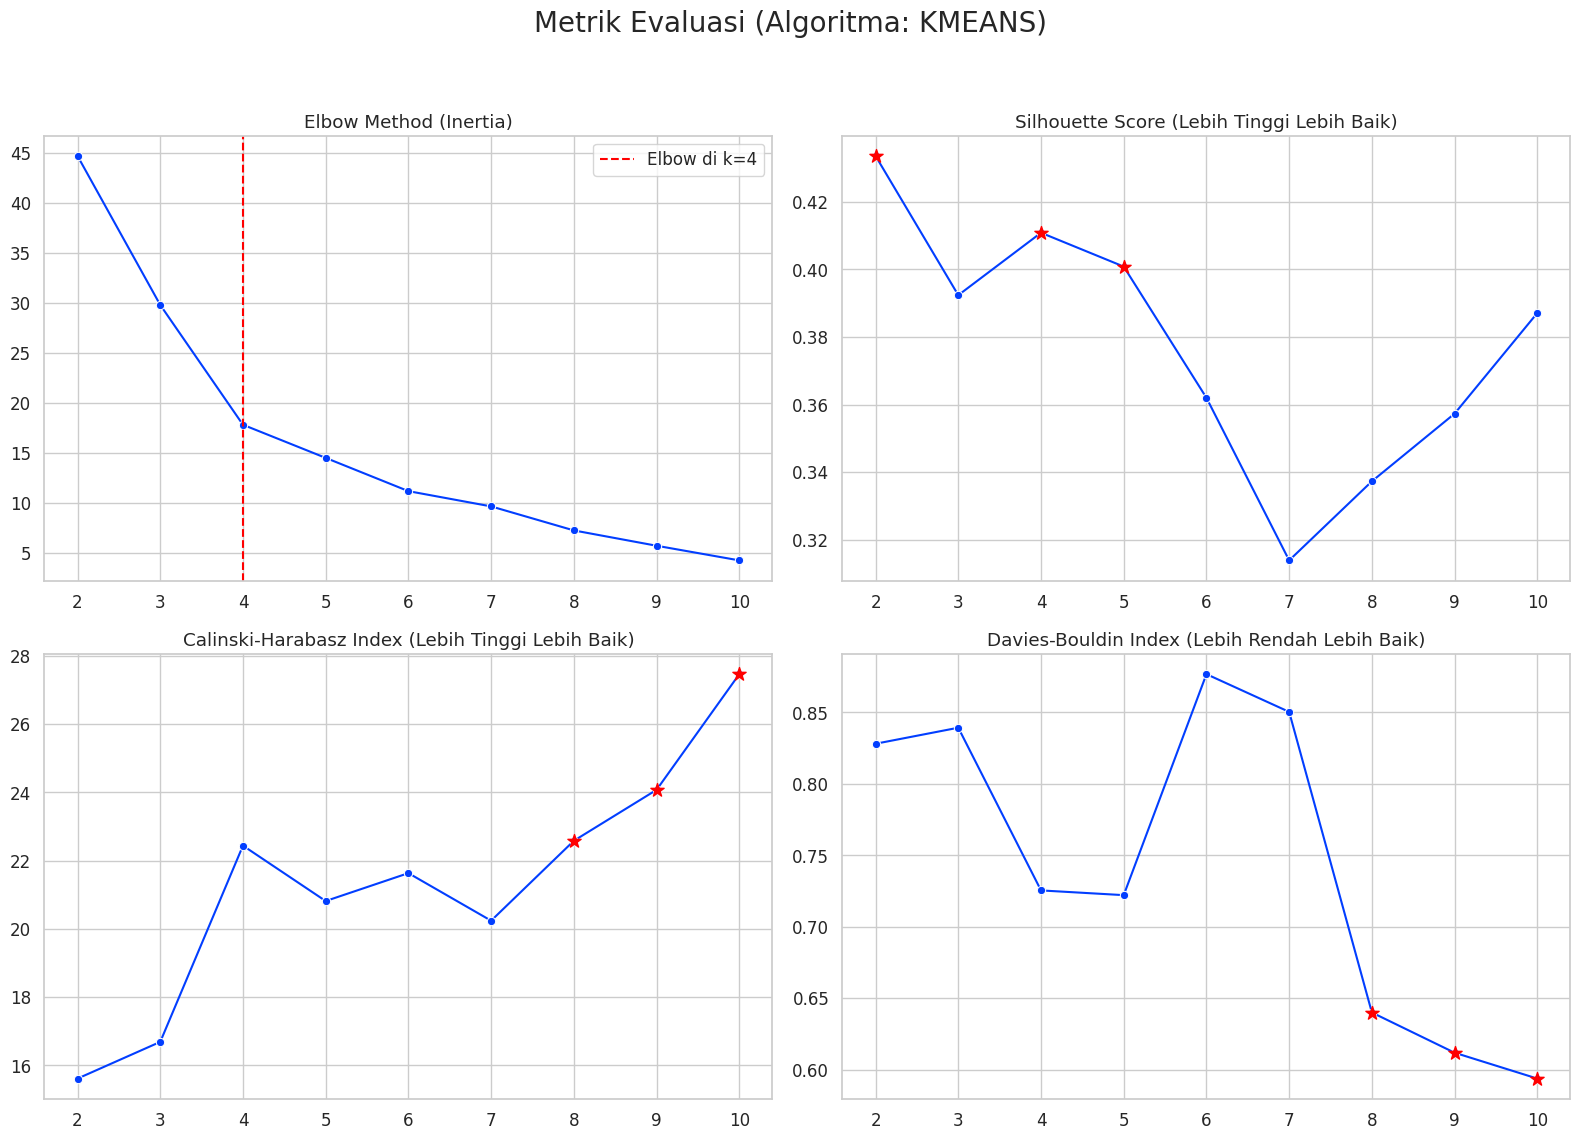

In [16]:
find_optimal_clusters(s1_features, max_k=10, algorithm='kmeans', scenario='s1')

In [17]:
# scaler = StandardScaler()
# data_numeric = s1_features.select_dtypes(include=np.number)
# data_scaled = scaler.fit_transform(data_numeric)

# # Get the scaled data for 'Bajeng Barat, Kabupaten Gowa'
# # bajeng_barat_scaled = data_scaled[s1_features.index == 'Bajeng Barat, Kabupaten Gowa'][0]

# # print("Data 'Bajeng Barat, Kabupaten Gowa' (setelah scaling):")
# # print(np.round(bajeng_barat_scaled, 4))

# # Display all scaled data in a DataFrame
# data_scaled_df = pd.DataFrame(data_scaled, index=s1_features.index, columns=s1_features.columns)
# print("\nSeluruh Data (setelah scaling):")
# display(data_scaled_df)

# # You can still run the demonstration steps if needed, but this fulfills the direct request
# # initial_centroids, first_iteration_distances, first_iteration_clusters, centroids_after_first_iteration, final_centroids, converged_iteration, first_iteration_assignments_with_features, final_clustering_details_df = demonstrate_kmeans_steps(data=s1_features, n_clusters=4)

# # print("\nPenentuan Klaster setelah Iterasi Pertama (dengan Fitur Asli):")
# # display(first_iteration_assignments_with_features)

# # print("\nJarak ke Centroid setelah Iterasi Pertama:")
# # display(first_iteration_distances)

# # # Create the requested DataFrame: original features with values replaced by distance to the first initial centroid
# # distance_to_first_centroid_df = pd.DataFrame(index=s1_features.index, columns=s1_features.columns)
# # distance_to_first_centroid_df.iloc[:, :] = first_iteration_distances['Jarak_ke_Centroid_1'].values[:, np.newaxis]


# # print("\nDataFrame dengan Jarak ke Centroid Pertama pada Iterasi Awal (menggantikan nilai fitur asli):")
# # display(distance_to_first_centroid_df)

In [18]:
# # Run K-Means for k=3 and get final centroids
# _, _, _, _, final_centroids_k3, _, _ = demonstrate_kmeans_steps(data=s1_features, n_clusters=3, max_iter=5)
# final_centroids_k3_df = pd.DataFrame(np.round(final_centroids_k3, 4), columns=s1_features.columns).T.rename(columns=lambda x: f'Centroid_k3_{x+1}')

# # Run K-Means for k=4 and get final centroids
# _, _, _, _, final_centroids_k4, _, _ = demonstrate_kmeans_steps(data=s1_features, n_clusters=4, max_iter=5)
# final_centroids_k4_df = pd.DataFrame(np.round(final_centroids_k4, 4), columns=s1_features.columns).T.rename(columns=lambda x: f'Centroid_k4_{x+1}')


# # Run K-Means for k=5 and get final centroids
# _, _, _, _, final_centroids_k5, _, _ = demonstrate_kmeans_steps(data=s1_features, n_clusters=5, max_iter=5)
# final_centroids_k5_df = pd.DataFrame(np.round(final_centroids_k5, 4), columns=s1_features.columns).T.rename(columns=lambda x: f'Centroid_k5_{x+1}')

# # Combine the final centroids for k=3, k=4, and k=5 into a single DataFrame
# comparison_centroids_k3_k4_k5 = pd.concat([final_centroids_k3_df, final_centroids_k4_df, final_centroids_k5_df], axis=1)

# print("\nPerbandingan Posisi Centroid Akhir (untuk k=3, k=4, dan k=5):")
# display(comparison_centroids_k3_k4_k5)

--- Profil untuk Setiap Klaster (k=5, Algoritma: kmeans) ---


Cluster,Fifth,First,Fourth,Second,Third
count,3.000000,3.000000,4.000000,2.000000,13.000000
total_kontak,441.333333,2701.666667,19407.000000,178.000000,6065.538462
kontak_serumah_rate,373.766158,173.253670,184.000828,549.160305,189.235741
rata_rata_umur,30.471937,38.549408,33.415849,32.684631,33.431009
latitude,NaN,NaN,NaN,NaN,NaN
longitude,NaN,NaN,NaN,NaN,NaN


/tmp/ipython-input-2500482967.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x=plot_df.PC1[i] + 0.03, y=plot_df.PC2[i] + 0.03, s=plot_df.index[i], fontdict=dict(color='black', size=10))


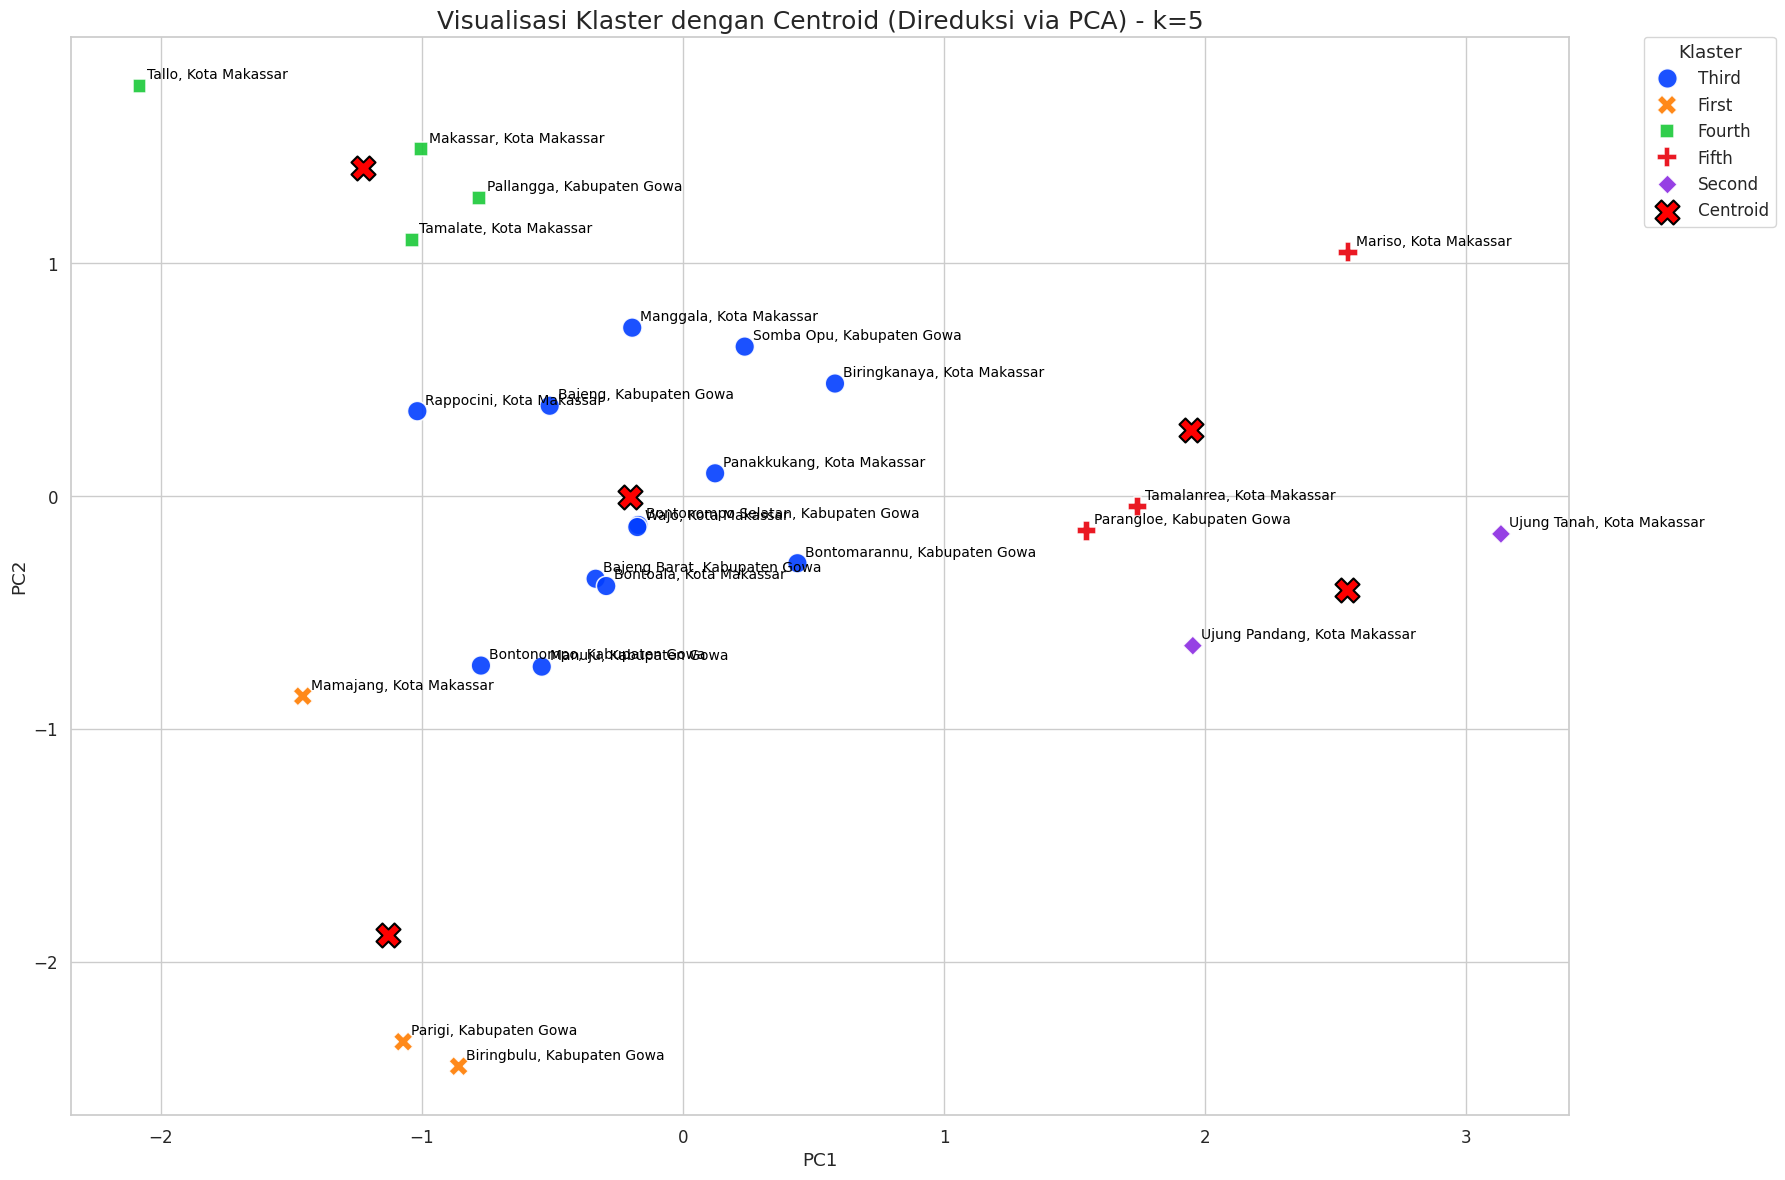

Hasil berhasil disimpan ke:
- result/skenario_1_kmeans_profile.json
- result/skenario_1_kmeans_results.json


In [19]:
results_s1_kmeans, profile_s1_kmeans = run_clustering_pipeline(data=s1_features, n_clusters=5, scenario_name='skenario_1_kmeans', algorithm='kmeans')

Untuk mendapatkan angka 2.0667, K-Means menghitung jarak Euclidean antara titik data 'Bajeng Barat, Kabupaten Gowa' (setelah scaling) dengan centroid pertama yang diinisialisasi secara acak (setelah scaling).

Rumus jarak Euclidean antara dua titik A dan B dengan n dimensi adalah:
$d(A, B) = \sqrt{(A_1 - B_1)^2 + (A_2 - B_2)^2 + ... + (A_n - B_n)^2}$

Dalam kasus ini, fitur yang digunakan adalah `total_kontak`, `kontak_serumah_rate`, dan `rata_rata_umur`.

In [20]:
# # Dapatkan data yang sudah diskalakan untuk 'Bajeng Barat, Kabupaten Gowa'
# scaler = StandardScaler()
# data_numeric = s1_features.select_dtypes(include=np.number)
# data_scaled = scaler.fit_transform(data_numeric)
# bajeng_barat_scaled = data_scaled[s1_features.index == 'Bajeng Barat, Kabupaten Gowa'][0]

# # Dapatkan centroid awal pertama (dari output demonstrate_kmeans_steps sebelumnya)
# # Pastikan Anda sudah menjalankan demonstrate_kmeans_steps dan menyimpan initial_centroids
# # initial_centroids, _, _, _, _ = demonstrate_kmeans_steps(data=s1_features, n_clusters=4, max_iter=5) # Jalankan ini jika belum

# initial_centroid_1 = initial_centroids.iloc[:, 0].values # Mengakses kolom pertama (Centroid_Awal_1)

# print("Data 'Bajeng Barat, Kabupaten Gowa' (setelah scaling):")
# print(np.round(bajeng_barat_scaled, 4))
# print("\nCentroid Awal Pertama (setelah scaling):")
# print(np.round(initial_centroid_1, 4))

# # Hitung jarak Euclidean secara manual
# distance_calculated = np.sqrt(np.sum((bajeng_barat_scaled - initial_centroid_1)**2))

# print(f"\nPerhitungan Jarak Euclidean:")
# print(f"sqrt(({bajeng_barat_scaled[0]:.4f} - {initial_centroid_1[0]:.4f})^2 + ({bajeng_barat_scaled[1]:.4f} - {initial_centroid_1[1]:.4f})^2 + ({bajeng_barat_scaled[2]:.4f} - {initial_centroid_1[2]:.4f})^2)")
# print(f"= {distance_calculated:.4f}")

# # Konfirmasi dengan nilai dari DataFrame
# distance_from_df = first_iter_distances.loc['Bajeng Barat, Kabupaten Gowa', 'Jarak_ke_Centroid_1']
# print(f"\nNilai jarak dari DataFrame first_iter_distances: {distance_from_df:.4f}")

**Bisecting K-Means**

In [21]:
# find_optimal_clusters(s1_features, max_k=10, algorithm='bisecting')
# demonstrate_bisecting_kmeans_steps(data=s1_features, n_clusters=4)
# results_s1_bisecting, profile_s1_bisecting = run_clustering_pipeline(data=s1_features, n_clusters=4, scenario_name='skenario_1_bisecting', algorithm='bisecting')

# Clustering berdasarkan Gejala Utama dan Gejala Tambahan

In [22]:
data2 = df_normalized.copy()

Fitur:
*   `batuk_rate`
*   `sesak_nafas_rate`
*   `keringat_malam_rate`
*   `demam_meriang_rate`

In [23]:
s2_features = data1[['batuk_rate', 'sesak_nafas_rate', 'keringat_malam_rate', 'demam_meriang_rate']]

**K-Means**

--- Rangkuman Metrik Evaluasi untuk Algoritma: KMEANS ---


,Inertia,Silhouette,Davies-Bouldin,Calinski-Harabasz
k,,,,
2,59.689879,0.400312,0.999253,15.532495
3,39.073485,0.447529,0.972551,17.152083
4,23.292601,0.484675,0.609059,23.052461
5,16.218925,0.408119,0.628649,25.828184
6,12.038441,0.397216,0.594691,27.765550
7,9.008581,0.372685,0.593571,30.301583
8,6.828915,0.383219,0.615449,33.134491
9,5.674113,0.354566,0.584018,33.247798
10,4.477483,0.383280,0.535394,35.556628



Tabel metrik evaluasi berhasil disimpan ke: result/kmeans_s2_metrics.csv

=> Rekomendasi Elbow Point (Inertia): k = 5
=> 3 Nilai k Terbaik (Silhouette): [4, 3, 5]
=> 3 Nilai k Terbaik (Davies-Bouldin): [10, 9, 7]
=> 3 Nilai k Terbaik (Calinski-Harabasz): [10, 9, 8]


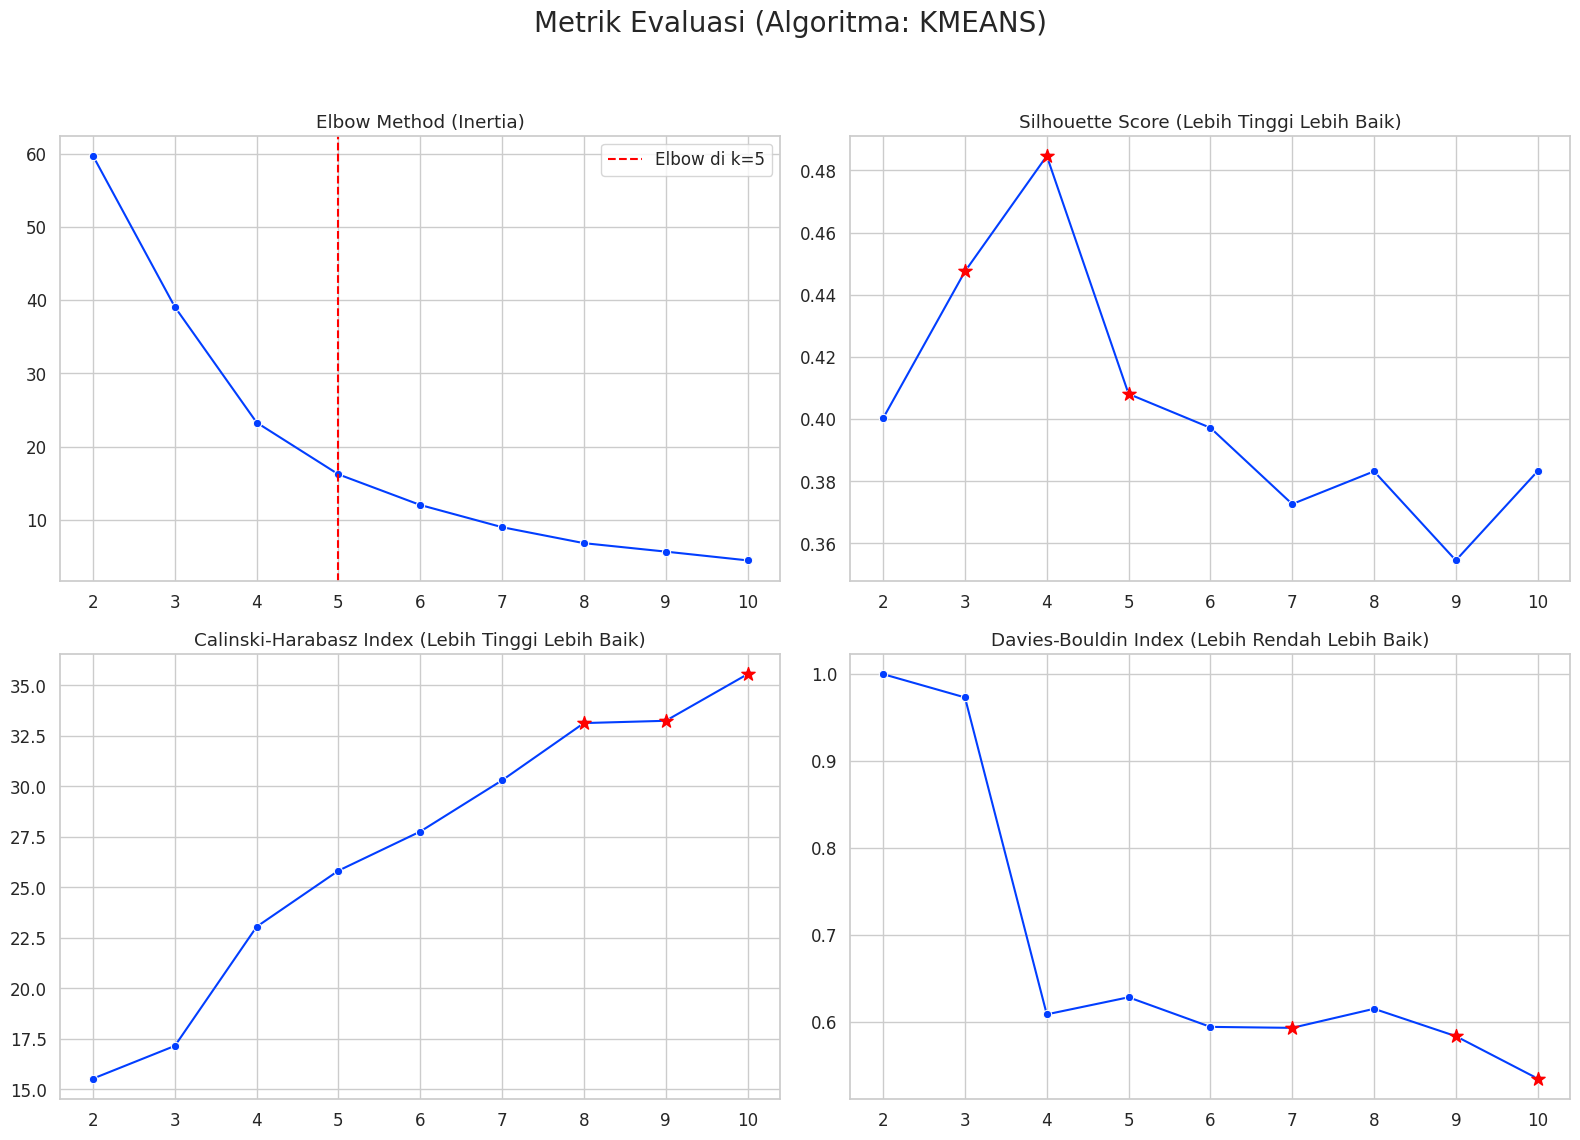

In [24]:
find_optimal_clusters(s2_features, max_k=10, algorithm='kmeans', scenario='s2')

In [25]:
demonstrate_kmeans_steps(data=s2_features, n_clusters=4)

--- DEMONSTRASI K-MEANS LANGKAH-DEMI-LANGKAH (target k=4) ---

Posisi Centroid Awal (Inisialisasi Acak):
[[-0.5055 -0.5448  1.5996  2.1191]
 [-0.0949 -0.3663 -1.0571 -0.9936]
 [ 0.584   1.5779 -0.3647 -0.922 ]
 [-0.9342 -0.7411 -1.0571 -0.9936]]

--- Iterasi: 1 ---
Jarak setiap titik ke setiap centroid:
[[4.3358 2.1737 0.     2.8578]
 [4.0297 2.0302 0.3506 2.7038]
 [6.0735 4.0901 4.1691 4.9122]
 [3.5772 0.8499 2.578  0.6856]
 [3.7297 0.9687 2.7643 0.3964]
 [3.834  1.1901 2.0142 1.9953]
 [2.9431 1.364  1.9915 1.7409]
 [5.1578 5.0132 2.9408 5.5925]
 [0.     4.1167 4.3358 4.1194]
 [1.5411 2.8034 2.9113 2.9736]
 [2.0968 2.0999 2.7288 2.1759]
 [3.2415 1.3208 2.4233 1.3055]
 [2.8662 1.3745 2.2958 1.4312]
 [1.4256 4.1617 3.6674 4.4093]
 [1.6752 2.8742 2.7745 3.006 ]
 [4.1609 0.4901 2.4483 1.1551]
 [4.1167 0.     2.1737 0.9192]
 [3.7746 0.7336 2.5292 0.4402]
 [0.6144 3.6457 3.8384 3.7427]
 [1.1508 3.8288 3.7813 3.9149]
 [2.7066 2.111  1.8142 2.6333]
 [1.8721 2.5459 2.5412 2.8581]
 [4.1312 1.01

,batuk_rate,sesak_nafas_rate,keringat_malam_rate,demam_meriang_rate,Distance_to_Centroid_1,Distance_to_Centroid_2,Distance_to_Centroid_3,Distance_to_Centroid_4,Final_Klaster_Terpilih
alamat,,,,,,,,,
"Bajeng Barat, Kabupaten Gowa",121.173236,56.461962,3.849679,0.549954,3.2479,4.1691,0.8573,2.3587,Third (2)
"Bajeng, Kabupaten Gowa",118.340164,50.307377,5.020492,1.434426,2.9336,4.1106,0.8020,2.1610,Third (2)
"Biringbulu, Kabupaten Gowa",375.000000,0.000000,0.000000,0.000000,5.2839,0.0000,4.3916,4.4497,Second (1)
"Biringkanaya, Kota Makassar",27.372591,4.862237,0.720331,4.502071,2.7921,4.6911,2.9262,0.3792,Fourth (3)
"Bontoala, Kota Makassar",8.292167,1.587862,1.235004,2.470007,2.9670,4.9194,3.1537,0.5224,Fourth (3)
"Bontomarannu, Kabupaten Gowa",147.694524,8.645533,2.881844,2.161383,2.8747,3.1164,2.3635,1.4040,Fourth (3)
"Bontonompo Selatan, Kabupaten Gowa",78.489030,13.797783,6.559602,4.976250,1.9425,4.2252,2.1176,1.0911,Fourth (3)
"Bontonompo, Kabupaten Gowa",164.293691,112.786153,11.166946,9.073143,4.3345,5.9014,2.3214,5.0429,Third (2)
"Makassar, Kota Makassar",39.692770,4.780320,14.770652,23.901601,1.1097,6.0735,3.8680,3.6469,First (0)



Posisi Centroid Akhir (setelah konvergensi/max iterasi):
[[-0.1804 -0.085   1.226   1.2389]
 [ 3.978  -0.7411 -1.0571 -0.9936]
 [ 0.6929  1.8292  0.1033 -0.2579]
 [-0.4422 -0.4913 -0.7637 -0.6572]]


(                     Centroid_Awal_1  Centroid_Awal_2  Centroid_Awal_3  \
 batuk_rate                   -0.5055          -0.0949           0.5840   
 sesak_nafas_rate             -0.5448          -0.3663           1.5779   
 keringat_malam_rate           1.5996          -1.0571          -0.3647   
 demam_meriang_rate            2.1191          -0.9936          -0.9220   
 
                      Centroid_Awal_4  
 batuk_rate                   -0.9342  
 sesak_nafas_rate             -0.7411  
 keringat_malam_rate          -1.0571  
 demam_meriang_rate           -0.9936  ,
                                     Jarak_ke_Centroid_1  Jarak_ke_Centroid_2  \
 alamat                                                                         
 Bajeng Barat, Kabupaten Gowa                     4.3358               2.1737   
 Bajeng, Kabupaten Gowa                           4.0297               2.0302   
 Biringbulu, Kabupaten Gowa                       6.0735               4.0901   
 Biringkanaya, Ko

--- Profil untuk Setiap Klaster (k=4, Algoritma: kmeans) ---


Cluster,First,Fourth,Second,Third
count,3.000000,9.000000,1.0,12.000000
batuk_rate,134.602363,69.503966,375.0,44.430546
sesak_nafas_rate,73.185164,17.618230,0.0,6.083163
keringat_malam_rate,6.679039,11.924285,0.0,1.631339
demam_meriang_rate,3.685841,16.519953,0.0,2.583466
latitude,NaN,NaN,NaN,NaN
longitude,NaN,NaN,NaN,NaN


/tmp/ipython-input-2500482967.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x=plot_df.PC1[i] + 0.03, y=plot_df.PC2[i] + 0.03, s=plot_df.index[i], fontdict=dict(color='black', size=10))


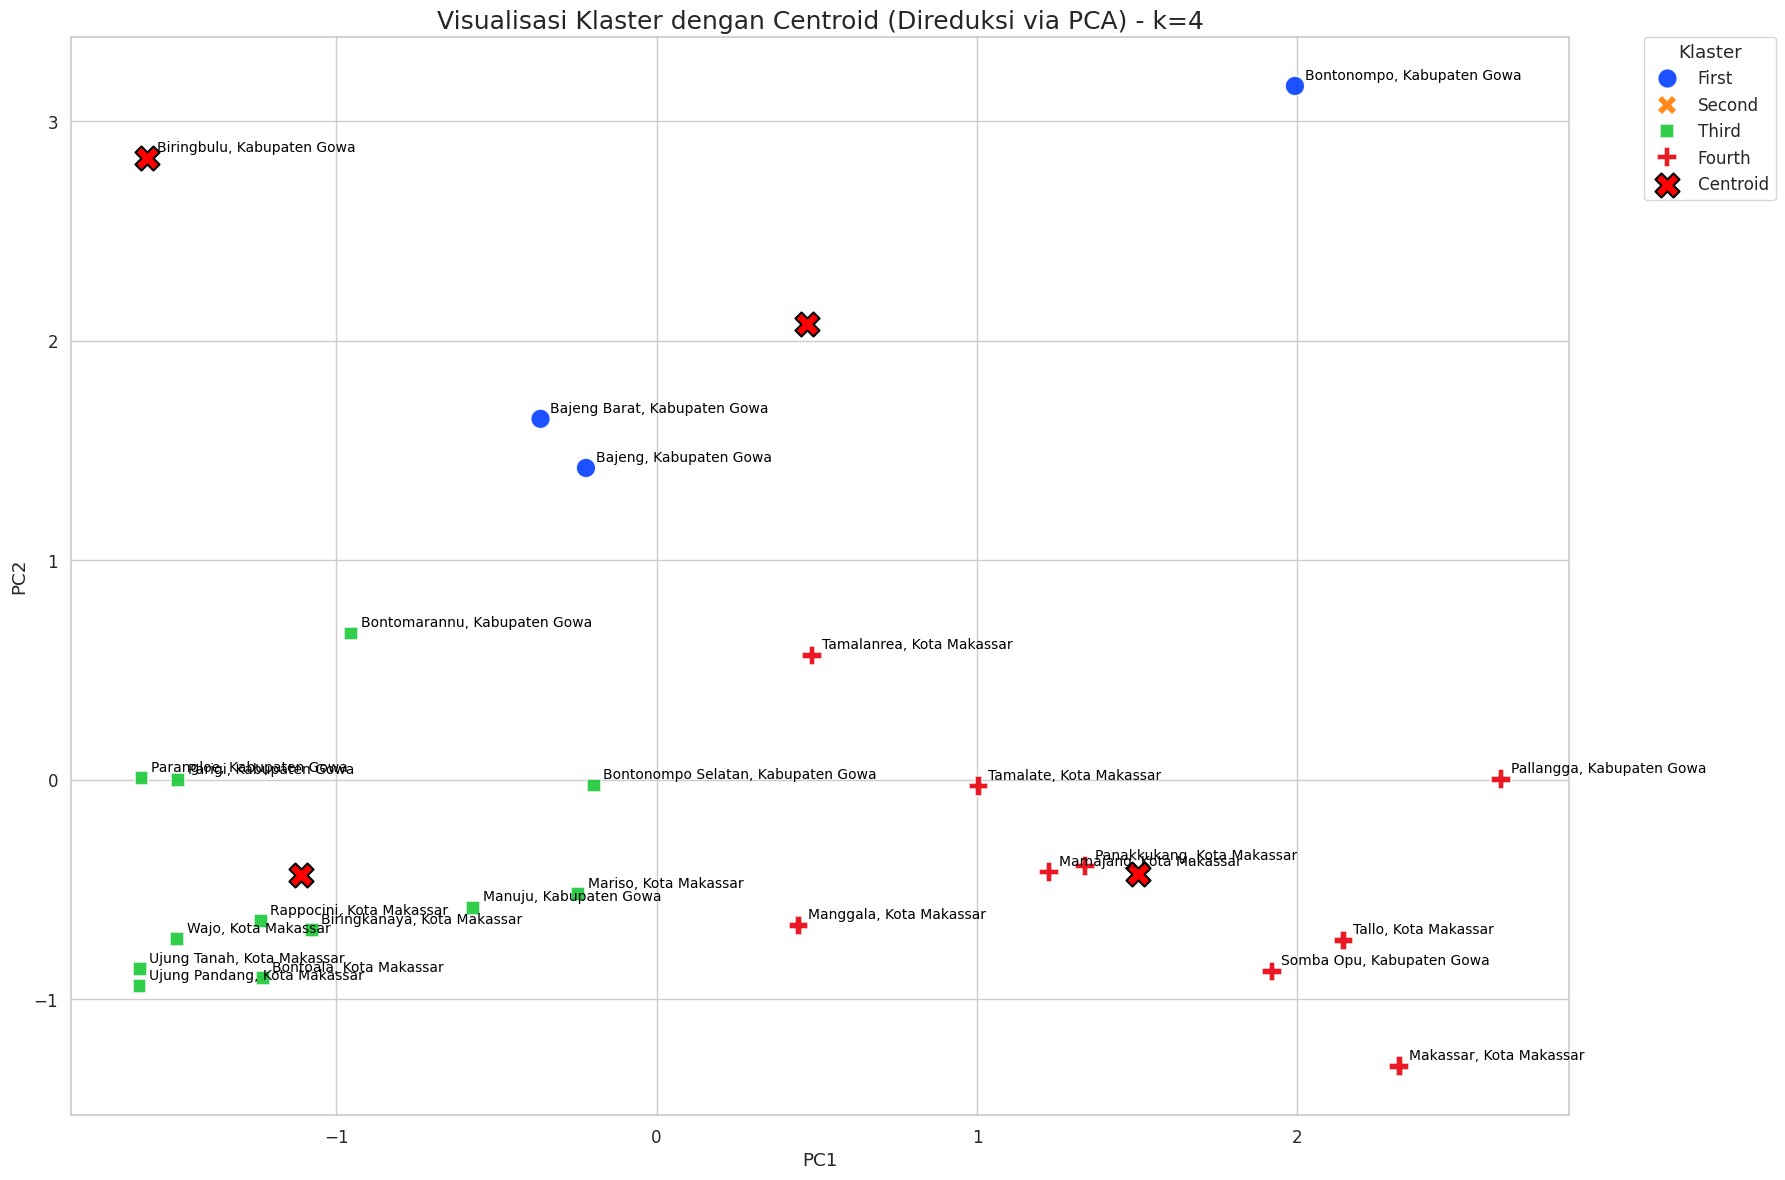

Hasil berhasil disimpan ke:
- result/skenario_2_kmeans_profile.json
- result/skenario_2_kmeans_results.json


In [26]:
results_s2_kmeans, profile_s2_kmeans = run_clustering_pipeline(data=s2_features, n_clusters=4, scenario_name='skenario_2_kmeans', algorithm='kmeans')

**Bisecting K-Means**

In [27]:
# find_optimal_clusters(s3_features, max_k=10, algorithm='bisecting')
# demonstrate_bisecting_kmeans_steps(data=s3_features, n_clusters=4)
# results_s3_bisecting, profile_s3_bisecting = run_clustering_pipeline(data=s3_features, n_clusters=4, scenario_name='skenario_3_bisecting', algorithm='bisecting')

# Clustering berdasarkan Faktor Risiko Individu

In [28]:
data3 = df_normalized.copy()

Fitur:
*   `lansia_rate`
*   `perokok_rate`
*   `diabetes_mellitus_rate`
*   `berobat_tidak_tuntas_rate`
*   `ibu_hamil_rate`

In [29]:
s3_features = data3[['lansia_rate','perokok_rate','diabetes_mellitus_rate','berobat_tidak_tuntas_rate', 'ibu_hamil_rate']]

**K-Means**

--- Rangkuman Metrik Evaluasi untuk Algoritma: KMEANS ---


,Inertia,Silhouette,Davies-Bouldin,Calinski-Harabasz
k,,,,
2,87.630661,0.321332,1.345237,9.808151
3,72.088684,0.324291,1.105010,8.073729
4,55.819626,0.332905,0.888873,8.675490
5,44.160644,0.345063,0.798205,9.152873
6,33.108055,0.349287,0.706053,10.546962
7,27.056899,0.204170,0.921598,10.859682
8,22.747393,0.209528,0.713963,10.916757
9,18.185341,0.209244,0.650177,11.747336
10,15.314855,0.199579,0.606902,11.936683



Tabel metrik evaluasi berhasil disimpan ke: result/kmeans_s3_metrics.csv

=> Rekomendasi Elbow Point (Inertia): k = 6
=> 3 Nilai k Terbaik (Silhouette): [6, 5, 4]
=> 3 Nilai k Terbaik (Davies-Bouldin): [10, 9, 6]
=> 3 Nilai k Terbaik (Calinski-Harabasz): [10, 9, 8]


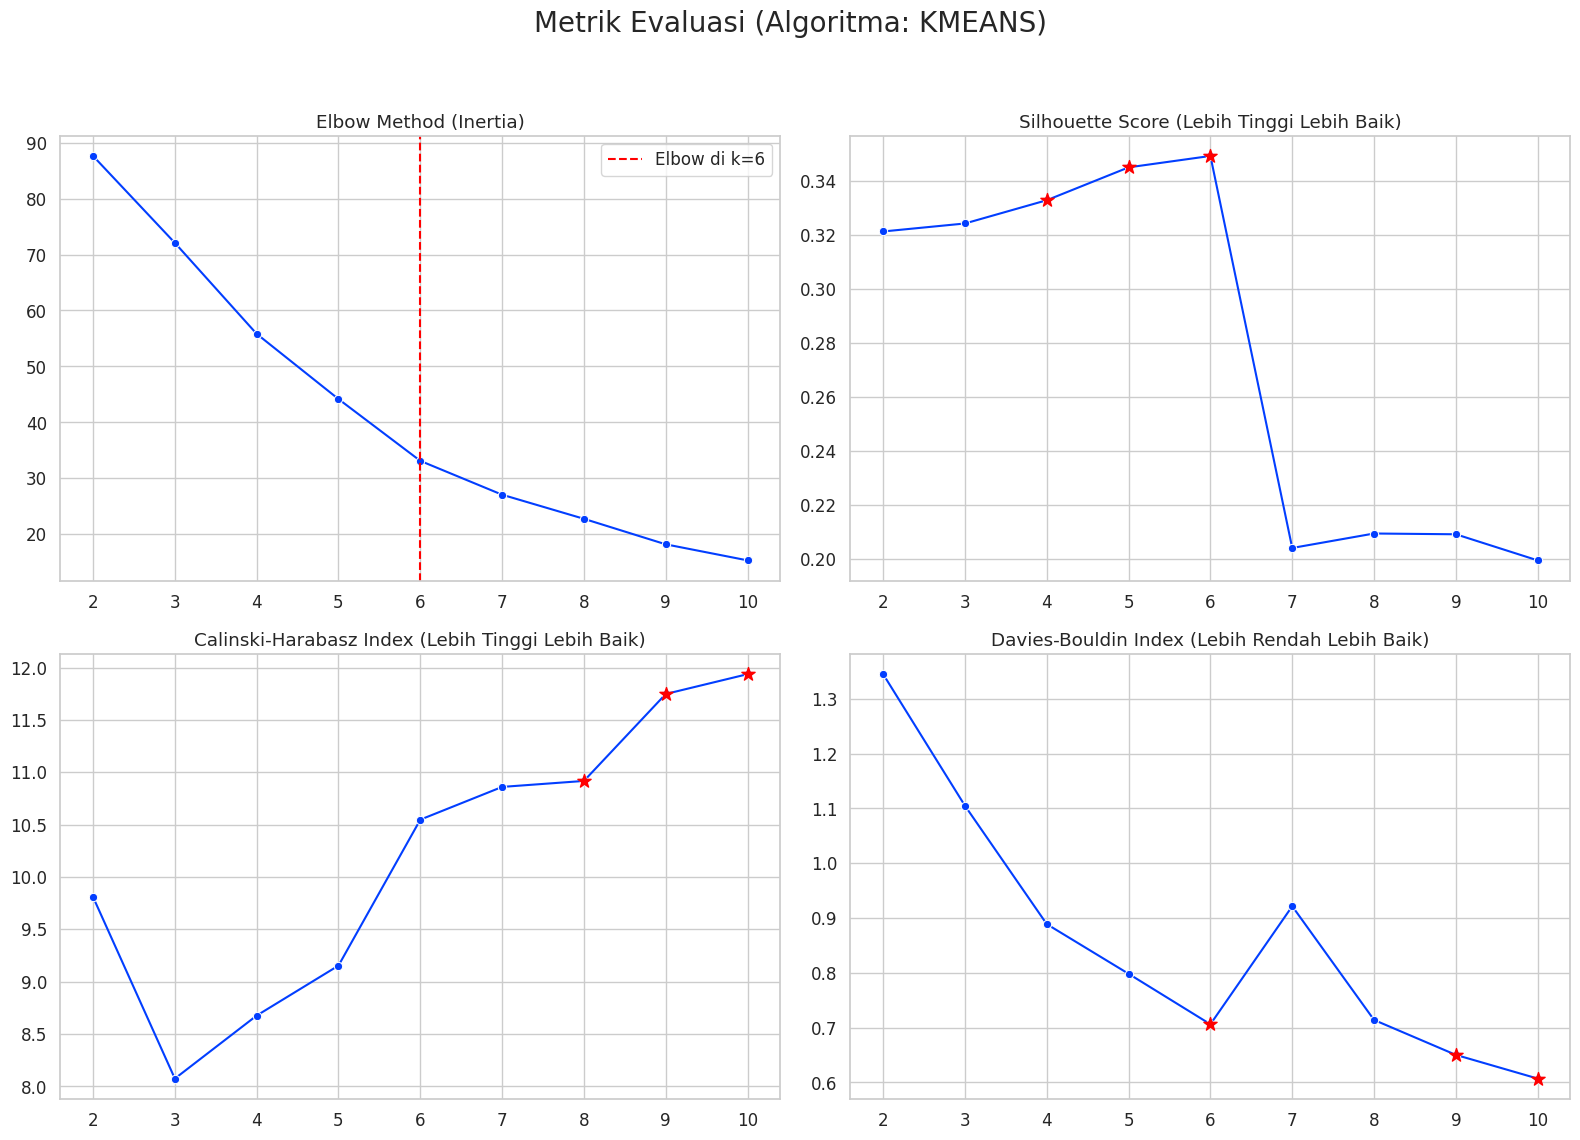

In [30]:
find_optimal_clusters(s3_features, max_k=10, algorithm='kmeans', scenario='s3')

In [31]:
demonstrate_kmeans_steps(data=s3_features, n_clusters=5)

--- DEMONSTRASI K-MEANS LANGKAH-DEMI-LANGKAH (target k=5) ---

Posisi Centroid Awal (Inisialisasi Acak):
[[-0.5663 -0.6912 -0.4233 -0.126  -0.6916]
 [ 3.0002 -1.162  -0.3996 -0.8232  1.0096]
 [ 0.9512 -1.136  -0.4036 -0.4832 -0.7646]
 [-1.6381 -0.6965 -0.6525 -0.8232 -0.7646]
 [ 0.4145  2.1814  0.2581 -0.8232 -0.7646]]

--- Iterasi: 1 ---
Jarak setiap titik ke setiap centroid:
[[1.623  2.7317 0.     2.6599 3.4418]
 [1.0977 3.0155 1.0062 2.1359 2.9191]
 [3.2198 5.5377 4.0031 3.2371 1.5478]
 [0.8832 3.8872 1.9541 1.3203 3.2185]
 [1.0728 3.5551 1.4739 2.0956 2.3308]
 [1.0107 3.556  1.1064 1.6378 3.5098]
 [3.8755 3.9029 3.9979 4.8002 4.361 ]
 [2.5194 2.5993 1.7058 3.7894 3.5672]
 [0.     4.04   1.623  1.301  3.189 ]
 [2.1052 2.9789 1.5946 3.0327 2.0337]
 [0.8857 3.5365 1.5961 1.7353 3.4835]
 [3.189  4.6307 3.4418 3.6503 0.    ]
 [2.4274 5.8729 3.7569 2.8083 4.2339]
 [5.3835 5.8673 5.5251 5.934  5.1165]
 [1.8136 4.0207 2.5976 2.6316 2.6047]
 [0.9973 4.1904 1.9654 1.2283 2.5953]
 [4.04   0. 

,lansia_rate,perokok_rate,diabetes_mellitus_rate,berobat_tidak_tuntas_rate,ibu_hamil_rate,Distance_to_Centroid_1,Distance_to_Centroid_2,Distance_to_Centroid_3,Distance_to_Centroid_4,Distance_to_Centroid_5,Final_Klaster_Terpilih
alamat,,,,,,,,,,,
"Bajeng Barat, Kabupaten Gowa",114.390467,21.448213,1.283226,0.183318,0.000000,3.1872,2.7317,0.9662,1.5385,3.5652,Third (2)
"Bajeng, Kabupaten Gowa",96.106557,58.709016,2.459016,0.204918,0.819672,2.3129,3.0155,0.6806,0.9876,2.8205,Third (2)
"Biringbulu, Kabupaten Gowa",62.500000,281.250000,0.000000,0.000000,0.000000,3.5069,5.5377,3.2459,3.1782,2.3768,Fifth (4)
"Biringkanaya, Kota Makassar",65.189987,60.507834,1.080497,0.180083,1.260580,2.1115,3.8872,1.6566,0.7018,2.9650,Fourth (3)
"Bontoala, Kota Makassar",91.743119,109.562456,1.058574,0.352858,0.176429,2.3340,3.5551,0.7026,1.1417,2.3840,Third (2)
"Bontomarannu, Kabupaten Gowa",84.293948,18.731988,0.000000,0.000000,0.000000,3.1423,3.5560,1.4366,0.7048,3.6359,Fourth (3)
"Bontonompo Selatan, Kabupaten Gowa",109.929880,118.977607,6.107216,1.357159,4.297670,1.8157,3.9029,3.4052,4.0405,3.2246,First (0)
"Bontonompo, Kabupaten Gowa",134.282524,49.413735,5.304299,0.837521,0.697934,2.7622,2.5993,1.4890,2.6926,3.1546,Third (2)
"Makassar, Kota Makassar",69.717478,53.818885,1.181652,0.375980,0.107423,2.4504,4.0400,1.3631,0.5335,2.9751,Fourth (3)



Posisi Centroid Akhir (setelah konvergensi/max iterasi):
[[-0.4649  0.2891  0.3206  0.8705  1.1757]
 [ 3.0002 -1.162  -0.3996 -0.8232  1.0096]
 [ 0.7179 -0.3065 -0.2171 -0.1469 -0.557 ]
 [-0.4975 -0.7129 -0.5508 -0.6164 -0.5411]
 [-0.1345  1.7426  1.0462  0.3532 -0.0982]]


(                           Centroid_Awal_1  Centroid_Awal_2  Centroid_Awal_3  \
 lansia_rate                        -0.5663           3.0002           0.9512   
 perokok_rate                       -0.6912          -1.1620          -1.1360   
 diabetes_mellitus_rate             -0.4233          -0.3996          -0.4036   
 berobat_tidak_tuntas_rate          -0.1260          -0.8232          -0.4832   
 ibu_hamil_rate                     -0.6916           1.0096          -0.7646   
 
                            Centroid_Awal_4  Centroid_Awal_5  
 lansia_rate                        -1.6381           0.4145  
 perokok_rate                       -0.6965           2.1814  
 diabetes_mellitus_rate             -0.6525           0.2581  
 berobat_tidak_tuntas_rate          -0.8232          -0.8232  
 ibu_hamil_rate                     -0.7646          -0.7646  ,
                                     Jarak_ke_Centroid_1  Jarak_ke_Centroid_2  \
 alamat                                             

--- Profil untuk Setiap Klaster (k=5, Algoritma: kmeans) ---


Cluster,Fifth,First,Fourth,Second,Third
count,2.000000,1.000000,2.000000,15.000000,5.000000
lansia_rate,80.545775,91.685071,55.211243,92.918619,80.546327
perokok_rate,272.080399,124.753775,172.607391,61.893479,132.160906
diabetes_mellitus_rate,2.347418,26.204262,3.522546,1.264454,5.438527
berobat_tidak_tuntas_rate,0.000000,0.537217,1.727935,0.205347,0.804856
ibu_hamil_rate,0.000000,2.984540,0.466729,0.471104,3.422041
latitude,NaN,NaN,NaN,NaN,NaN
longitude,NaN,NaN,NaN,NaN,NaN


/tmp/ipython-input-2500482967.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x=plot_df.PC1[i] + 0.03, y=plot_df.PC2[i] + 0.03, s=plot_df.index[i], fontdict=dict(color='black', size=10))


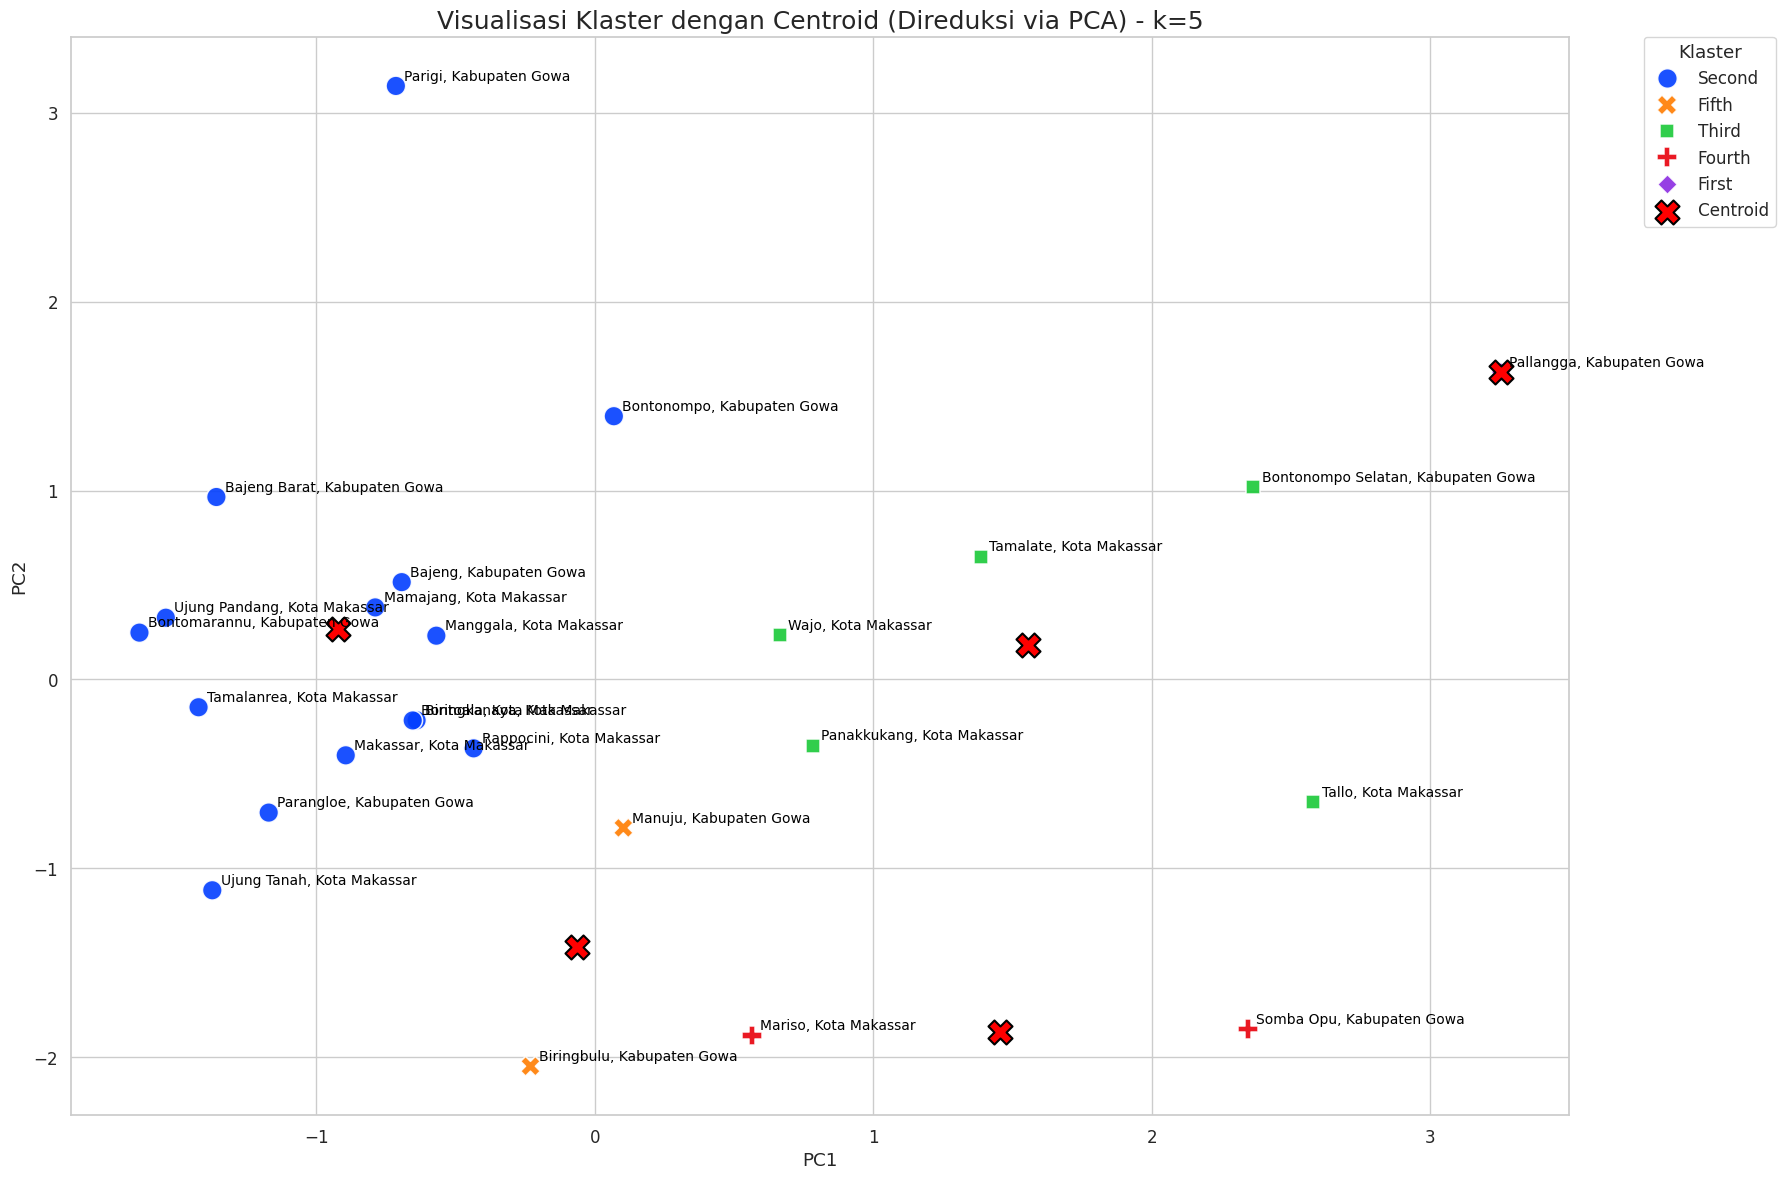

Hasil berhasil disimpan ke:
- result/skenario_3_kmeans_profile.json
- result/skenario_3_kmeans_results.json


In [32]:
results_s3_kmeans, profile_s3_kmeans = run_clustering_pipeline(data=s3_features, n_clusters=5, scenario_name='skenario_3_kmeans', algorithm='kmeans')

**Bisecting K-Means**

In [33]:
# find_optimal_clusters(s4_features, max_k=10, algorithm='bisecting')
# demonstrate_bisecting_kmeans_steps(data=s4_features, n_clusters=5)
# results_s4_bisecting, profile_s4_bisecting = run_clustering_pipeline(data=s4_features, n_clusters=5, scenario_name='skenario_4_bisecting', algorithm='bisecting')

# Clustering berdasarkan Demografi Kontak Tuberkulosis

In [34]:
data4 = df_normalized.copy()

Fitur:
*   `rata_rata_umur`
*   `laki-laki_rate`
*   `perempuan_rate`
*   `ibu_hamil_rate`

In [35]:
s4_features = data4[['rata_rata_umur', 'laki-laki_rate', 'perempuan_rate', 'ibu_hamil_rate']]

**K-Means**

--- Rangkuman Metrik Evaluasi untuk Algoritma: KMEANS ---


,Inertia,Silhouette,Davies-Bouldin,Calinski-Harabasz
k,,,,
2,63.325402,0.343843,1.103598,13.320338
3,43.743153,0.326636,0.937294,14.146792
4,32.761067,0.288163,0.921987,14.366826
5,27.657295,0.303658,0.898140,13.078413
6,21.591177,0.336616,0.737857,13.799782
7,16.570767,0.319192,0.684320,15.104171
8,12.670477,0.334509,0.688106,16.738594
9,10.591618,0.344098,0.505921,16.882856
10,7.590191,0.340378,0.520572,20.291497



Tabel metrik evaluasi berhasil disimpan ke: result/kmeans_s4_metrics.csv

=> Rekomendasi Elbow Point (Inertia): k = 4
=> 3 Nilai k Terbaik (Silhouette): [9, 2, 10]
=> 3 Nilai k Terbaik (Davies-Bouldin): [9, 10, 7]
=> 3 Nilai k Terbaik (Calinski-Harabasz): [10, 9, 8]


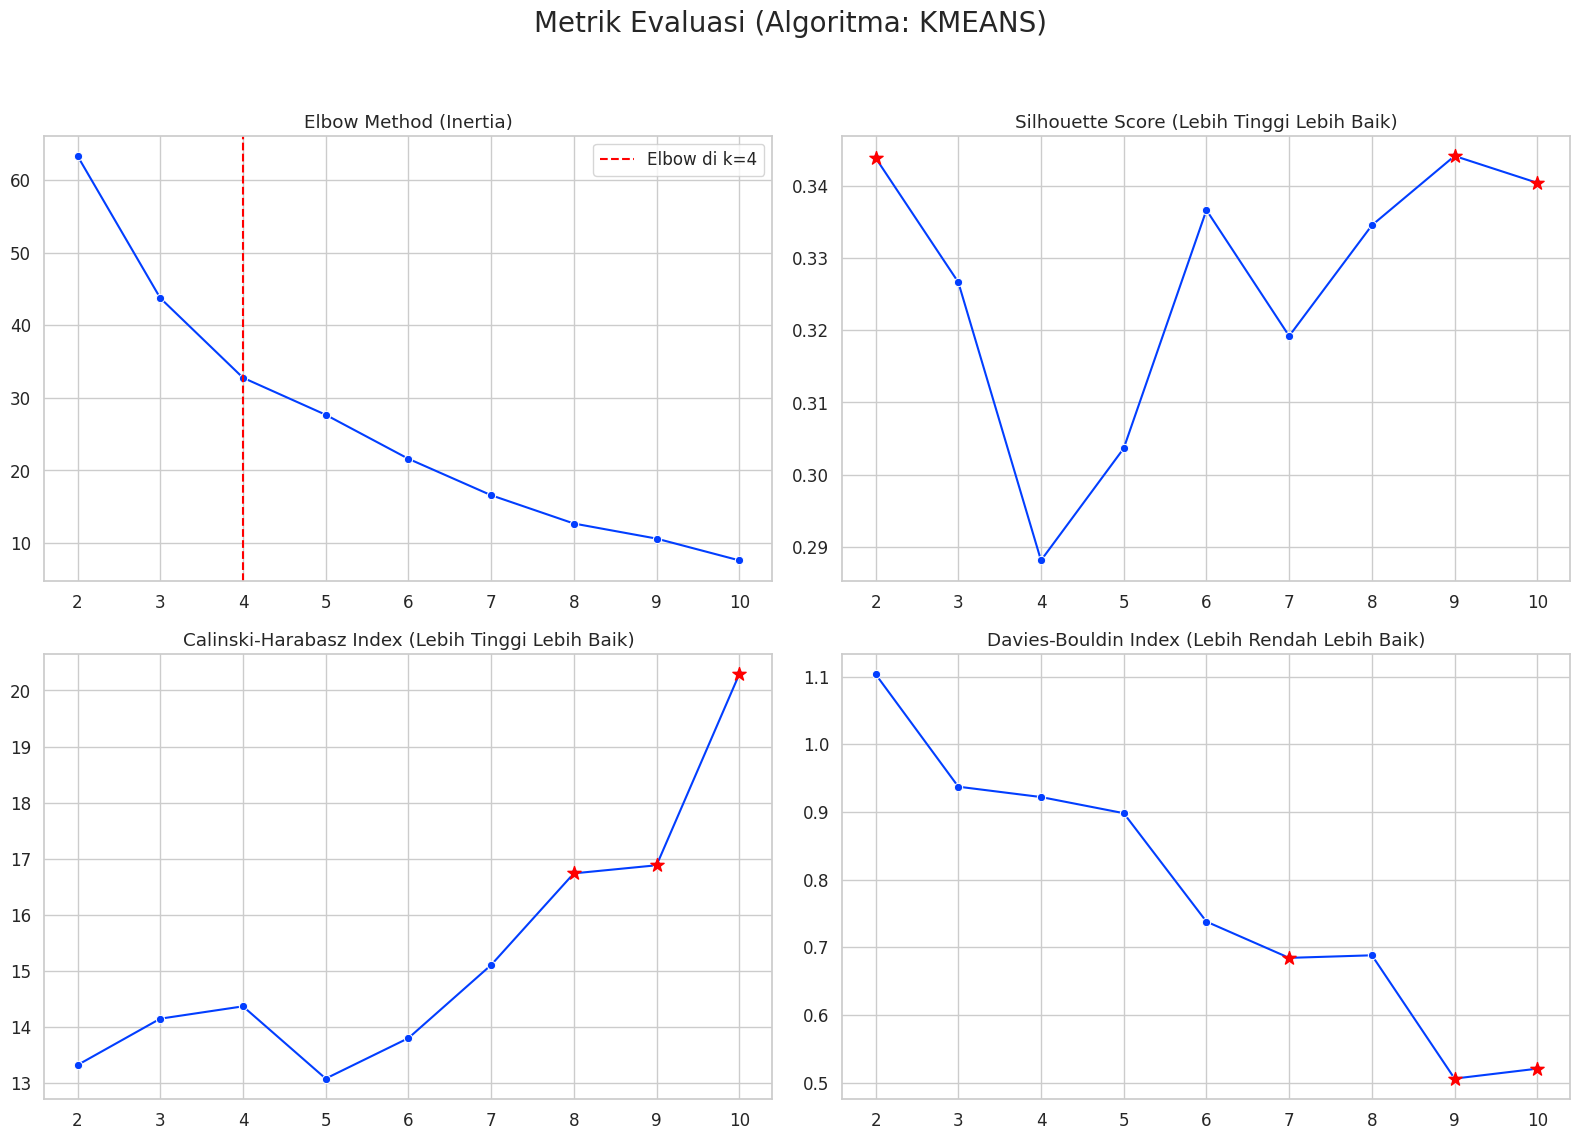

In [36]:
find_optimal_clusters(s4_features, max_k=10, algorithm='kmeans', scenario='s4')

In [37]:
demonstrate_kmeans_steps(data=s4_features, n_clusters=9)

--- DEMONSTRASI K-MEANS LANGKAH-DEMI-LANGKAH (target k=9) ---

Posisi Centroid Awal (Inisialisasi Acak):
[[-0.3225  0.9939 -0.9939 -0.6916]
 [ 2.4378 -0.4546  0.4546  1.0096]
 [ 0.323   0.4861 -0.4861 -0.7646]
 [-0.7447  2.6876 -2.6876 -0.7646]
 [ 0.2017 -1.729   1.729  -0.7646]
 [ 1.3134 -0.5112  0.5112 -0.6715]
 [-0.3057  0.5118 -0.5118  1.2661]
 [-0.0857  0.0781 -0.0781 -0.2069]
 [-0.0512 -1.2691  1.2691 -0.7646]]

--- Iterasi: 1 ---
Jarak setiap titik ke setiap centroid:
[[0.9684 3.0643 0.     3.2915 3.1349 1.7259 2.1262 0.9006 2.5103]
 [1.403  2.901  0.9006 3.7901 2.6314 1.6935 1.6107 0.     1.9854]
 [5.5973 3.3131 4.6563 7.9259 2.4837 2.9578 5.4048 4.4147 3.0169]
 [0.9669 3.8788 1.5407 2.7396 3.8904 2.9939 1.3781 1.3647 3.2168]
 [0.9799 2.9694 0.1532 3.2657 3.1979 1.7291 2.0367 0.9103 2.5816]
 [1.8808 3.3333 1.3562 4.2894 2.0559 1.7132 2.3583 0.8586 1.3619]
 [3.2646 2.8776 3.0868 4.9711 3.7187 3.2373 1.2767 2.3849 3.344 ]
 [2.9694 1.9326 2.0676 5.322  1.6369 0.6205 2.8261 1.7486 

,rata_rata_umur,laki-laki_rate,perempuan_rate,ibu_hamil_rate,Distance_to_Centroid_1,Distance_to_Centroid_2,Distance_to_Centroid_3,Distance_to_Centroid_4,Distance_to_Centroid_5,Distance_to_Centroid_6,Distance_to_Centroid_7,Distance_to_Centroid_8,Distance_to_Centroid_9,Final_Klaster_Terpilih
alamat,,,,,,,,,,,,,,
"Bajeng Barat, Kabupaten Gowa",34.393767,488.359303,511.640697,0.000000,1.4597,3.0643,0.0766,3.2915,4.6563,1.8790,2.6118,1.1899,2.8183,Third (2)
"Bajeng, Kabupaten Gowa",33.424795,481.250000,518.750000,0.819672,1.4319,2.9010,0.9022,3.7901,4.4147,1.6931,1.9515,0.4267,2.3047,Eighth (7)
"Biringbulu, Kabupaten Gowa",39.500000,437.500000,562.500000,0.000000,5.7935,3.3131,4.6646,7.9259,0.0000,2.8137,5.0574,4.2656,2.7411,Fifth (4)
"Biringkanaya, Kota Makassar",31.614983,494.687556,505.312444,1.260580,0.5713,3.8788,1.5286,2.7396,5.7746,3.0287,2.1142,1.5945,3.5524,First (0)
"Bontoala, Kota Makassar",34.574277,489.061397,510.938603,0.176429,1.4928,2.9694,0.0766,3.2657,4.6741,1.8807,2.5249,1.2400,2.8851,Third (2)
"Bontomarannu, Kabupaten Gowa",32.729827,474.063401,525.936599,0.000000,1.7894,3.3333,1.4016,4.2894,4.1188,1.6815,2.5889,0.4934,1.7085,Eighth (7)
"Bontonompo Selatan, Kabupaten Gowa",33.252658,477.719973,522.280027,4.297670,3.0604,2.8776,3.0445,4.9711,5.1141,3.0714,0.5043,2.5052,3.5191,Seventh (6)
"Bontonompo, Kabupaten Gowa",36.250558,465.522055,534.477945,0.697934,3.1613,1.9326,2.0664,5.3220,2.6977,0.3103,2.6907,1.6904,1.4827,Sixth (5)
"Makassar, Kota Makassar",32.863412,497.207004,502.792996,0.107423,0.7739,3.8354,0.9712,2.4333,5.5973,2.8136,2.7688,1.6751,3.5487,First (0)



Posisi Centroid Akhir (setelah konvergensi/max iterasi):
[[-1.019   0.8262 -0.8262 -0.4515]
 [ 2.4378 -0.4546  0.4546  1.0096]
 [ 0.3611  0.5062 -0.5062 -0.7046]
 [-0.7447  2.6876 -2.6876 -0.7646]
 [ 2.4772 -2.4329  2.4329 -0.7646]
 [ 1.2099 -0.6679  0.6679 -0.4806]
 [-0.1114  0.0752 -0.0752  1.7444]
 [-0.3018 -0.1643  0.1643 -0.3409]
 [ 0.0753 -1.499   1.499  -0.7646]]


(                Centroid_Awal_1  Centroid_Awal_2  Centroid_Awal_3  \
 rata_rata_umur          -0.3225           2.4378           0.3230   
 laki-laki_rate           0.9939          -0.4546           0.4861   
 perempuan_rate          -0.9939           0.4546          -0.4861   
 ibu_hamil_rate          -0.6916           1.0096          -0.7646   
 
                 Centroid_Awal_4  Centroid_Awal_5  Centroid_Awal_6  \
 rata_rata_umur          -0.7447           0.2017           1.3134   
 laki-laki_rate           2.6876          -1.7290          -0.5112   
 perempuan_rate          -2.6876           1.7290           0.5112   
 ibu_hamil_rate          -0.7646          -0.7646          -0.6715   
 
                 Centroid_Awal_7  Centroid_Awal_8  Centroid_Awal_9  
 rata_rata_umur          -0.3057          -0.0857          -0.0512  
 laki-laki_rate           0.5118           0.0781          -1.2691  
 perempuan_rate          -0.5118          -0.0781           1.2691  
 ibu_hamil_rate     

--- Profil untuk Setiap Klaster (k=9, Algoritma: kmeans) ---


Cluster,Eighth,Fifth,First,Fourth,Ninth,Second,Seventh,Sixth,Third
count,1.000000,4.000000,1.0,2.000000,1.000000,8.000000,2.000000,5.000000,1.000000
rata_rata_umur,31.862595,32.015549,39.5,36.496002,39.406780,33.305485,33.806385,33.363918,28.000000
laki-laki_rate,526.717557,495.221706,437.5,468.252404,471.968709,479.948524,453.771518,481.200220,490.538574
perempuan_rate,473.282443,504.778294,562.5,531.747596,528.031291,520.051476,546.228482,518.799780,509.461426
ibu_hamil_rate,0.000000,0.575365,0.0,0.417404,2.607562,0.489167,0.000000,3.687518,0.000000
latitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
longitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipython-input-2500482967.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x=plot_df.PC1[i] + 0.03, y=plot_df.PC2[i] + 0.03, s=plot_df.index[i], fontdict=dict(color='black', size=10))


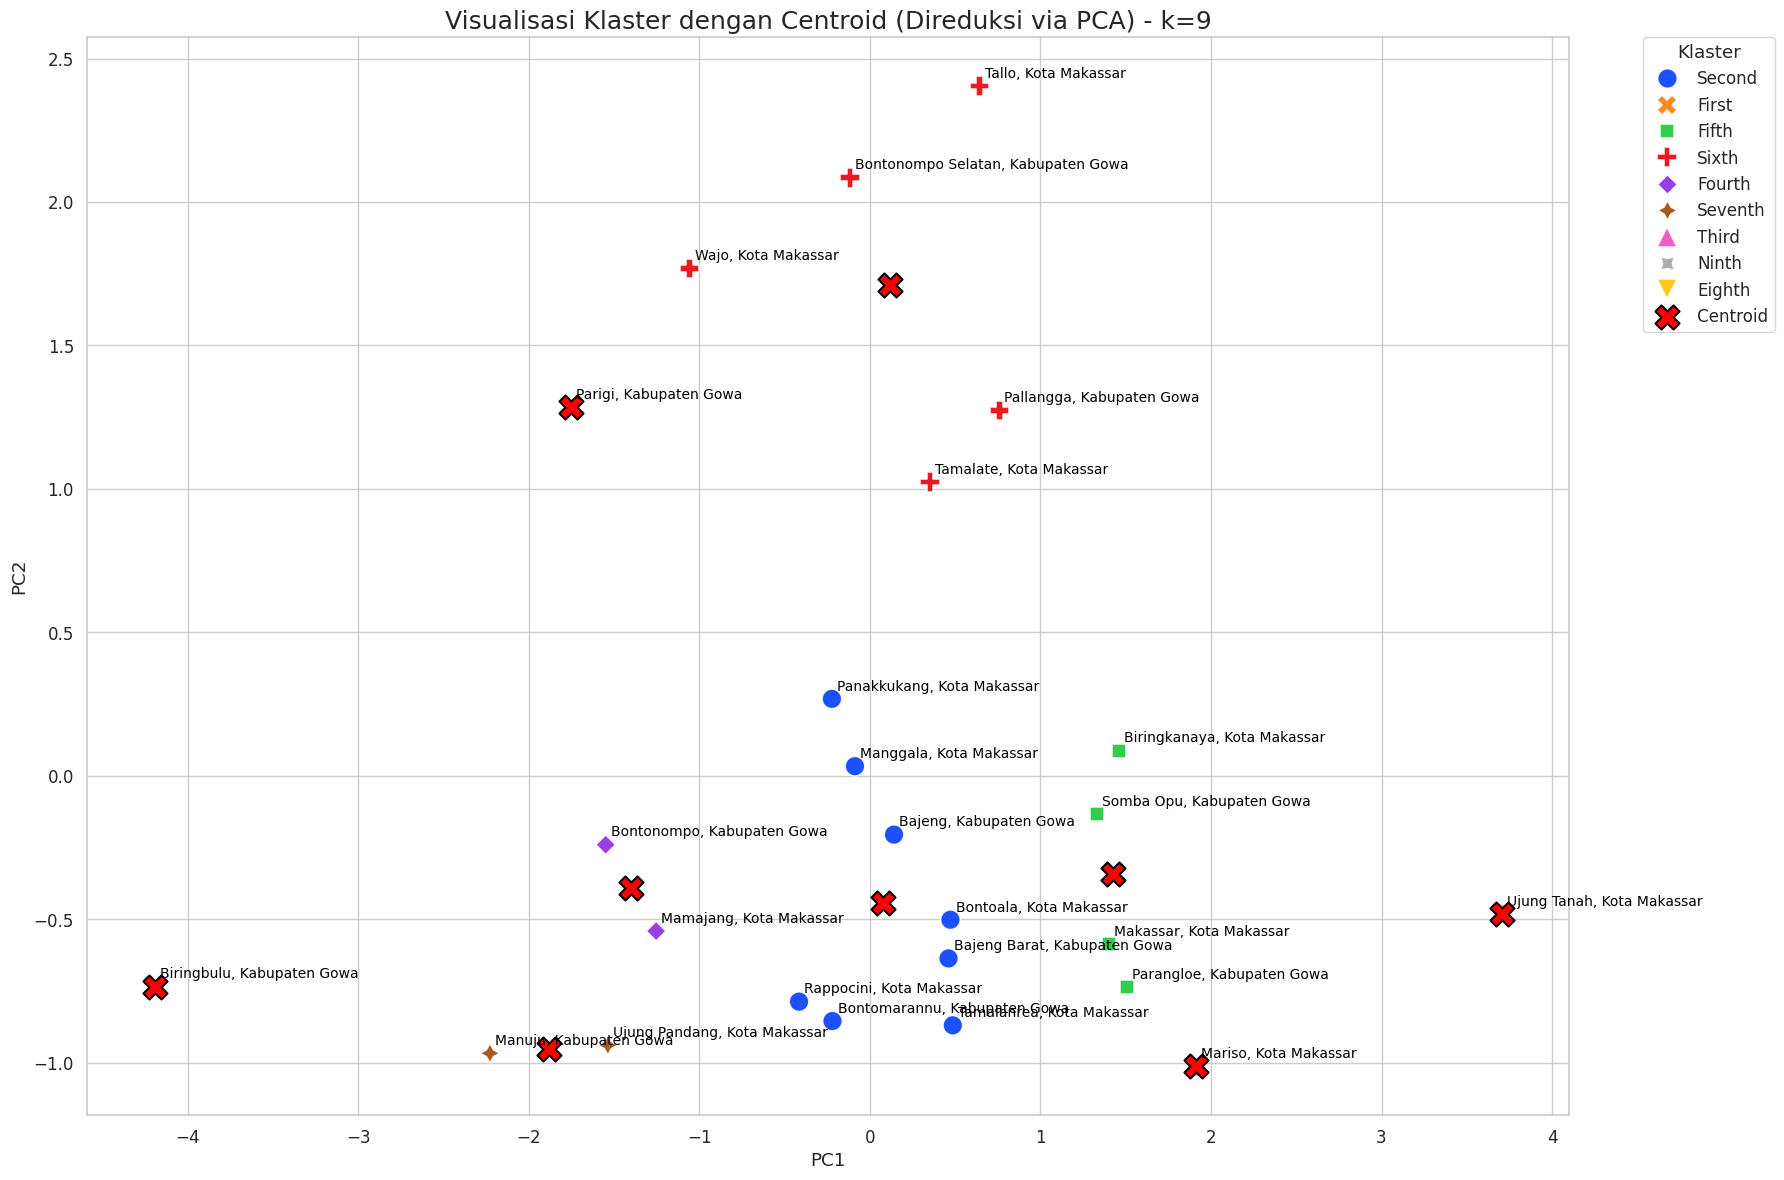

Hasil berhasil disimpan ke:
- result/skenario_4_kmeans_profile.json
- result/skenario_4_kmeans_results.json


In [38]:
results_s4_kmeans, profile_s4_kmeans = run_clustering_pipeline(data=s4_features, n_clusters=9, scenario_name='skenario_4_kmeans', algorithm='kmeans')

**Bisecting K-Means**

In [39]:
# find_optimal_clusters(s5_features, max_k=10, algorithm='bisecting')
# demonstrate_bisecting_kmeans_steps(data=s5_features, n_clusters=9)
# results_s5_bisecting, profile_s5_bisecting = run_clustering_pipeline(data=s5_features, n_clusters=9, scenario_name='skenario_5_bisecting', algorithm='bisecting')

# Clustering berdasarkan Alur Pasien & Beban Layanan

In [40]:
data5 = df_normalized.copy()

Fitur:
*   `dirujuk_rate`
*   `jumlah_fasyankes_unik`
*   `berobat_tidak_tuntas_rate`
*   `total_kontak`

In [41]:
s5_features = data5[['dirujuk_rate', 'jumlah_fasyankes_unik', 'berobat_tidak_tuntas_rate', 'total_kontak']]

**K-Means**

--- Rangkuman Metrik Evaluasi untuk Algoritma: KMEANS ---


,Inertia,Silhouette,Davies-Bouldin,Calinski-Harabasz
k,,,,
2,70.510057,0.260460,1.406316,9.619460
3,53.965992,0.286896,1.148323,9.383207
4,36.785442,0.332480,0.808599,12.029267
5,25.732865,0.362160,0.713756,14.430405
6,19.981228,0.333569,0.718490,15.217850
7,15.895199,0.315688,0.749712,15.873623
8,13.254878,0.325274,0.671564,15.893524
9,11.883669,0.298707,0.562964,14.829819
10,9.373782,0.272746,0.652752,16.113421



Tabel metrik evaluasi berhasil disimpan ke: result/kmeans_s5_metrics.csv

=> Rekomendasi Elbow Point (Inertia): k = 5
=> 3 Nilai k Terbaik (Silhouette): [5, 6, 4]
=> 3 Nilai k Terbaik (Davies-Bouldin): [9, 10, 8]
=> 3 Nilai k Terbaik (Calinski-Harabasz): [10, 8, 7]


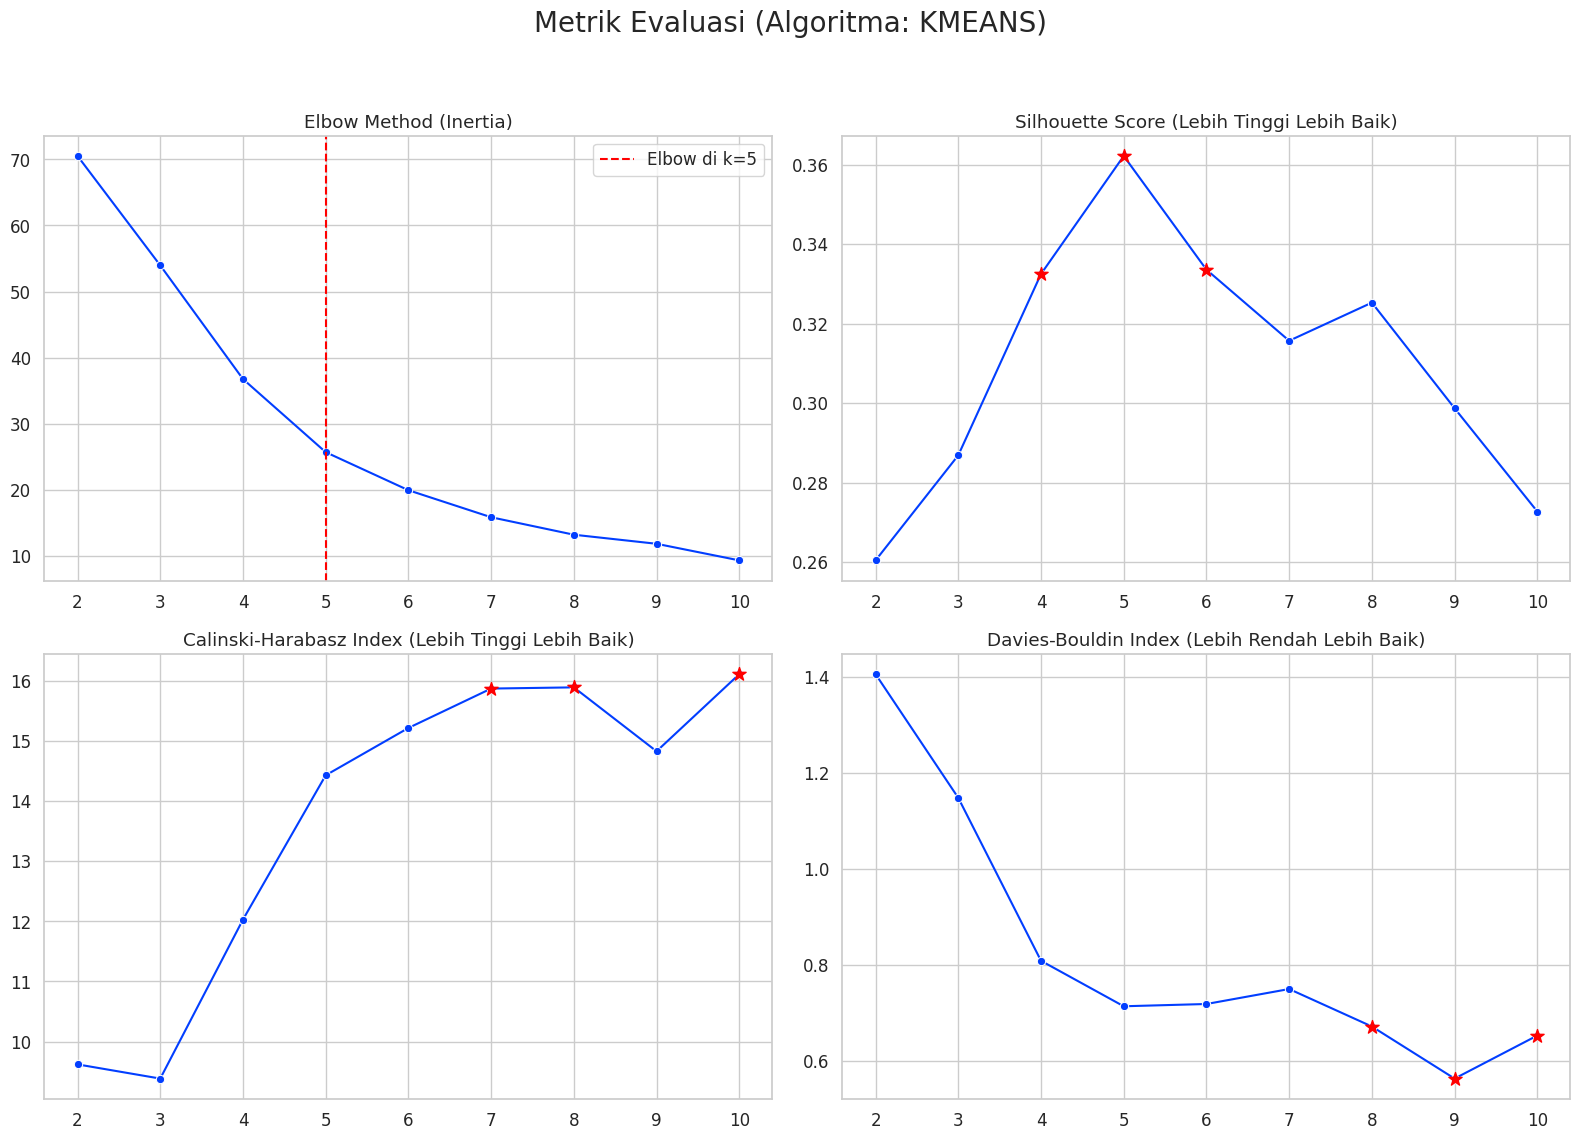

In [42]:
find_optimal_clusters(s5_features, max_k=10, algorithm='kmeans', scenario='s5')

In [43]:
demonstrate_kmeans_steps(data=s5_features, n_clusters=5)

--- DEMONSTRASI K-MEANS LANGKAH-DEMI-LANGKAH (target k=5) ---

Posisi Centroid Awal (Inisialisasi Acak):
[[-0.5543  0.2471 -0.126   1.7849]
 [-0.088  -0.911  -0.8232 -0.8775]
 [ 0.6186 -0.911  -0.4832 -0.1783]
 [-1.0516 -0.525  -0.8232 -0.9724]
 [-0.875  -0.911  -0.8232 -0.8331]]

--- Iterasi: 1 ---
Jarak setiap titik ke setiap centroid:
[[2.5882 1.0506 0.     1.9196 1.6658]
 [1.9062 1.5759 0.7546 2.1752 1.9924]
 [5.4901 4.0772 3.4814 5.0541 4.8651]
 [2.1333 2.1772 2.3463 1.8064 2.0762]
 [2.1172 1.3601 1.6435 1.0588 1.0265]
 [3.258  1.0157 0.7592 2.0211 1.7991]
 [3.0751 2.577  2.2649 2.8327 2.7151]
 [2.8161 2.209  1.3527 2.9245 2.7167]
 [0.     3.0221 2.5882 2.9886 2.9637]
 [1.9519 2.1781 2.0944 2.1031 2.2792]
 [1.2728 2.6436 2.414  2.4988 2.6318]
 [2.9637 0.7882 1.6658 0.4468 0.    ]
 [3.3893 2.8079 2.6893 2.8788 2.9047]
 [1.1476 2.6274 1.8981 2.9462 2.7839]
 [3.1113 3.825  3.8055 3.5046 3.8037]
 [3.1667 0.3151 0.9565 1.3211 1.0959]
 [3.0221 0.     1.0506 1.0424 0.7882]
 [1.4615 2.677

,dirujuk_rate,jumlah_fasyankes_unik,berobat_tidak_tuntas_rate,total_kontak,Distance_to_Centroid_1,Distance_to_Centroid_2,Distance_to_Centroid_3,Distance_to_Centroid_4,Distance_to_Centroid_5,Final_Klaster_Terpilih
alamat,,,,,,,,,,
"Bajeng Barat, Kabupaten Gowa",124.289643,1.0,0.183318,5455.0,2.6253,0.6052,2.3358,2.4837,1.6059,Second (1)
"Bajeng, Kabupaten Gowa",118.237705,2.0,0.204918,9760.0,1.9630,1.2068,2.3771,2.2225,1.7983,Second (1)
"Biringbulu, Kabupaten Gowa",375.000000,1.0,0.000000,32.0,5.3450,2.9902,4.6664,4.9110,4.8363,Second (1)
"Biringkanaya, Kota Makassar",25.031514,6.0,0.180083,5553.0,1.9104,2.5949,2.9623,0.6306,1.5755,Fourth (3)
"Bontoala, Kota Makassar",7.762879,2.0,0.352858,5668.0,2.1944,2.1152,2.2839,2.0612,0.7713,Fifth (4)
"Bontomarannu, Kabupaten Gowa",146.974063,1.0,0.000000,1388.0,3.2570,0.2872,2.7822,2.6915,1.8067,Second (1)
"Bontonompo Selatan, Kabupaten Gowa",79.167609,1.0,1.357159,4421.0,2.8228,2.6150,0.3721,3.0910,2.5926,Third (2)
"Bontonompo, Kabupaten Gowa",164.572864,1.0,0.837521,7164.0,2.6397,1.5733,1.4963,2.9402,2.5943,Third (2)
"Makassar, Kota Makassar",37.007197,4.0,0.375980,18618.0,0.7267,3.0866,3.0315,2.4041,2.6470,First (0)



Posisi Centroid Akhir (setelah konvergensi/max iterasi):
[[-0.318   0.6974  0.3057  1.4966]
 [ 1.0318 -0.8467 -0.7032 -0.5564]
 [ 0.2072 -0.6215  1.7965 -0.2547]
 [-0.2584  1.4052 -0.3348 -0.2905]
 [-0.8155 -0.4478 -0.6923 -0.692 ]]


(                           Centroid_Awal_1  Centroid_Awal_2  Centroid_Awal_3  \
 dirujuk_rate                       -0.5543          -0.0880           0.6186   
 jumlah_fasyankes_unik               0.2471          -0.9110          -0.9110   
 berobat_tidak_tuntas_rate          -0.1260          -0.8232          -0.4832   
 total_kontak                        1.7849          -0.8775          -0.1783   
 
                            Centroid_Awal_4  Centroid_Awal_5  
 dirujuk_rate                       -1.0516          -0.8750  
 jumlah_fasyankes_unik              -0.5250          -0.9110  
 berobat_tidak_tuntas_rate          -0.8232          -0.8232  
 total_kontak                       -0.9724          -0.8331  ,
                                     Jarak_ke_Centroid_1  Jarak_ke_Centroid_2  \
 alamat                                                                         
 Bajeng Barat, Kabupaten Gowa                     2.5882               1.0506   
 Bajeng, Kabupaten Gowa           

--- Profil untuk Setiap Klaster (k=5, Algoritma: kmeans) ---


Cluster,Fifth,First,Fourth,Second,Third
count,6.000000,11.000000,1.0,4.000000,3.000000
dirujuk_rate,46.492434,68.077099,375.0,93.673884,59.650089
jumlah_fasyankes_unik,7.166667,2.090909,1.0,1.750000,3.333333
berobat_tidak_tuntas_rate,0.432305,0.067372,0.0,1.412638,0.704033
total_kontak,9528.833333,2551.000000,32.0,4942.750000,20409.333333
latitude,NaN,NaN,NaN,NaN,NaN
longitude,NaN,NaN,NaN,NaN,NaN


/tmp/ipython-input-2500482967.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x=plot_df.PC1[i] + 0.03, y=plot_df.PC2[i] + 0.03, s=plot_df.index[i], fontdict=dict(color='black', size=10))


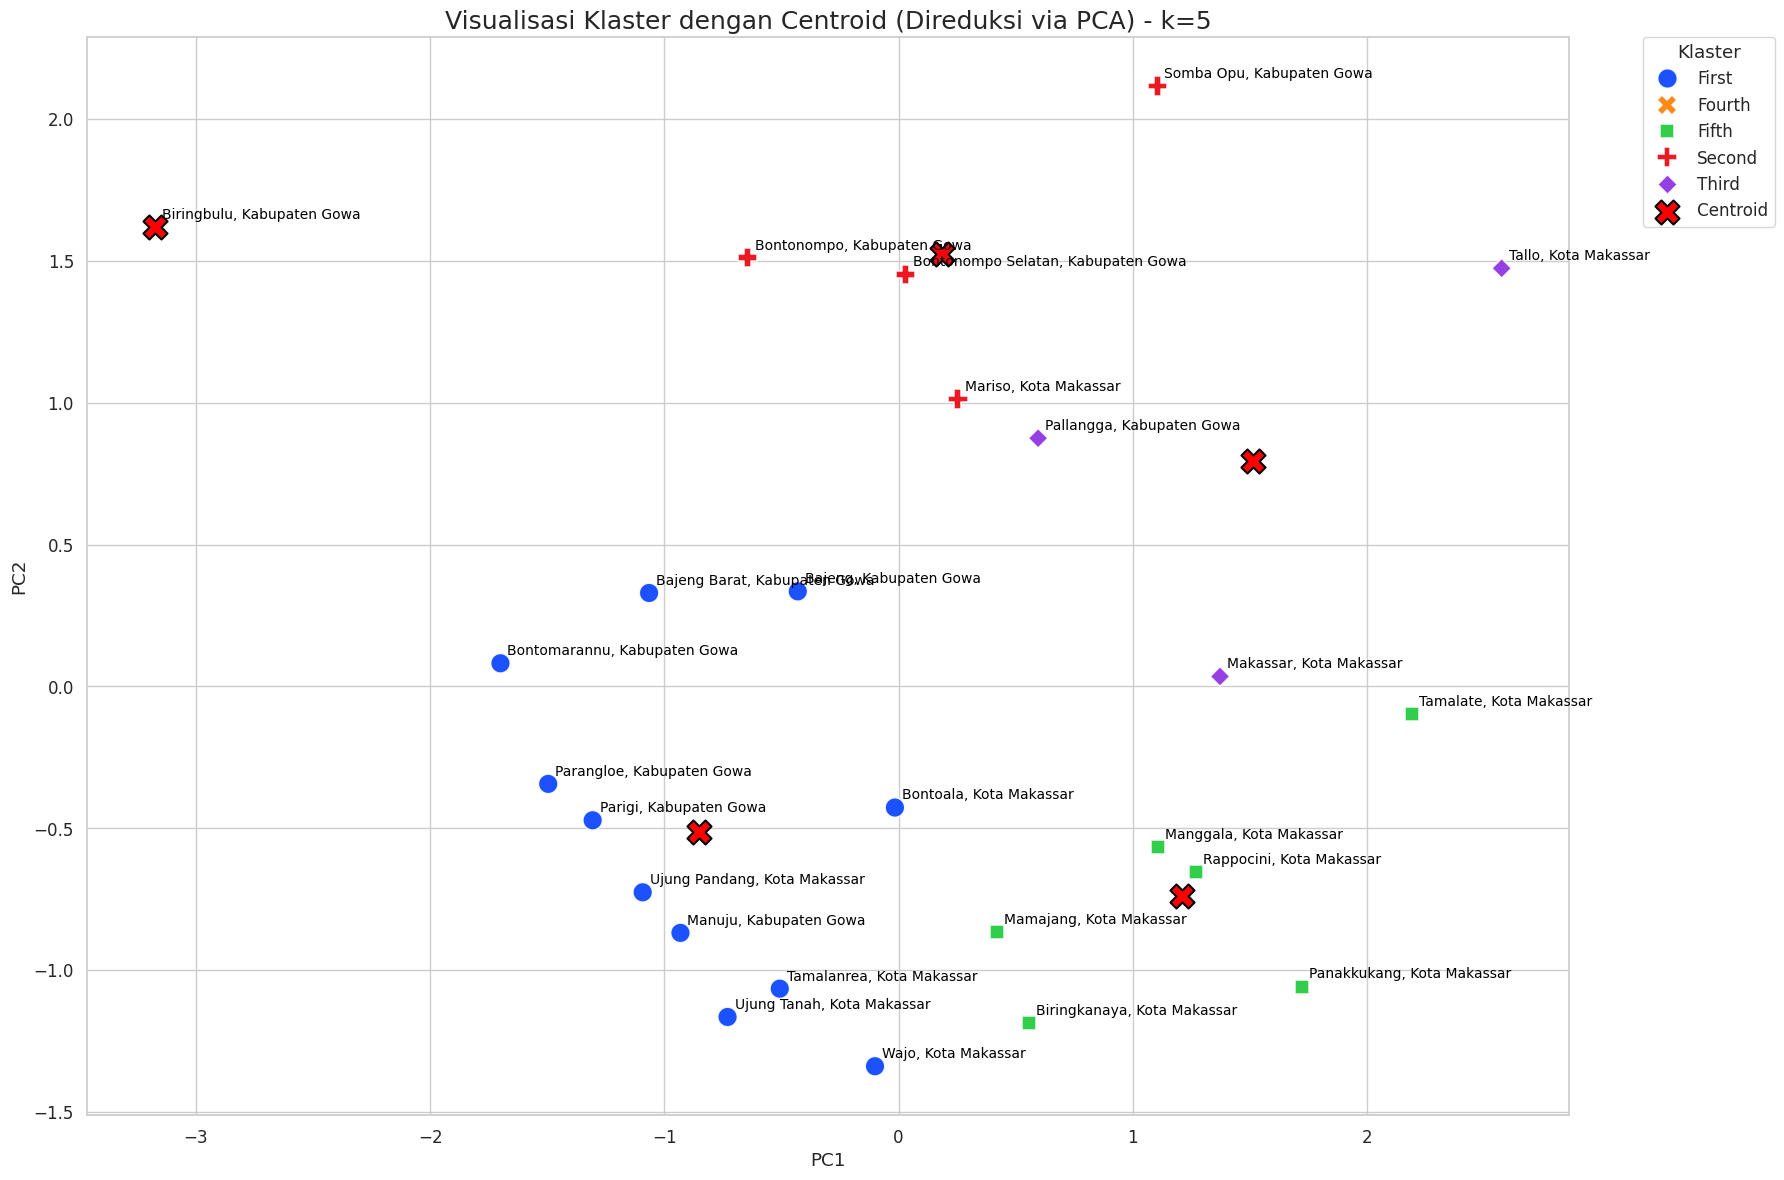

Hasil berhasil disimpan ke:
- result/skenario_5_kmeans_profile.json
- result/skenario_5_kmeans_results.json


In [44]:
results_s5_kmeans, profile_s5_kmeans = run_clustering_pipeline(data=s5_features, n_clusters=5, scenario_name='skenario_5_kmeans', algorithm='kmeans')

**Bisecting K-Means**

In [45]:
# find_optimal_clusters(s6_features, max_k=10, algorithm='bisecting')
# demonstrate_bisecting_kmeans_steps(data=s6_features, n_clusters=5)
# results_s6_bisecting, profile_s6_bisecting = run_clustering_pipeline(data=s6_features, n_clusters=5, scenario_name='skenario_6_bisecting', algorithm='bisecting')

# Clustering berdasarkan Geospasial dan Akses Layanan

In [46]:
data6 = df_normalized.copy()

Fitur:
*   `latitude`
*   `longitude`
*   `jumlah_fasyankes_unik`

In [47]:
s6_features = data6[['latitude', 'longitude', 'jumlah_fasyankes_unik']]

**K-Means**

--- Rangkuman Metrik Evaluasi untuk Algoritma: KMEANS ---


,Inertia,Silhouette,Davies-Bouldin,Calinski-Harabasz
k,,,,
2,39.832015,0.414946,0.957304,20.306873
3,25.118200,0.406281,0.780092,21.844710
4,15.719222,0.409186,0.754084,26.398599
5,12.110246,0.406293,0.728778,25.965514
6,9.473509,0.419934,0.595358,26.283889
7,7.090933,0.380670,0.611344,28.730660
8,5.240102,0.404056,0.513320,32.330839
9,3.584747,0.407999,0.474757,39.843954
10,2.867123,0.391899,0.507274,41.931039



Tabel metrik evaluasi berhasil disimpan ke: result/kmeans_s6_metrics.csv

=> Rekomendasi Elbow Point (Inertia): k = 4
=> 3 Nilai k Terbaik (Silhouette): [6, 2, 4]
=> 3 Nilai k Terbaik (Davies-Bouldin): [9, 10, 8]
=> 3 Nilai k Terbaik (Calinski-Harabasz): [10, 9, 8]


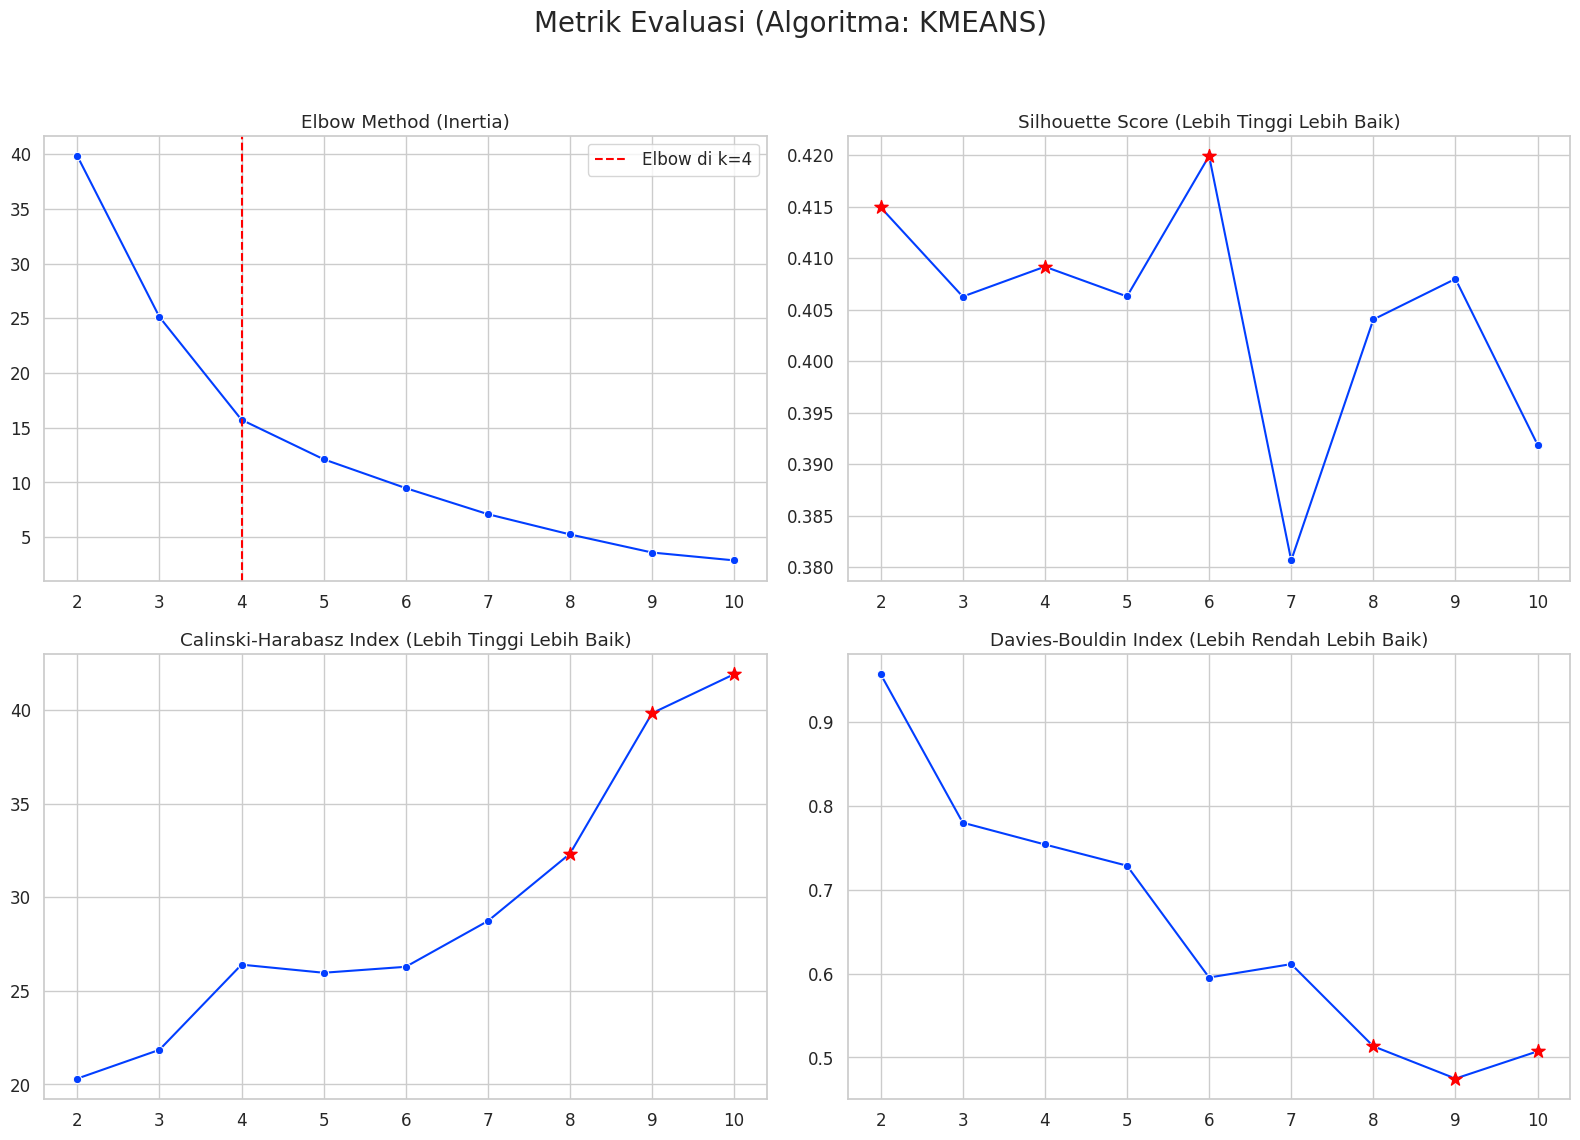

In [48]:
find_optimal_clusters(s6_features, max_k=10, algorithm='kmeans', scenario='s6')

In [49]:
demonstrate_kmeans_steps(data=s6_features, n_clusters=6)

--- DEMONSTRASI K-MEANS LANGKAH-DEMI-LANGKAH (target k=6) ---

Posisi Centroid Awal (Inisialisasi Acak):
[[ 0.5403 -0.4141  0.2471]
 [-0.9395  3.0067 -0.911 ]
 [-0.7777 -0.8331 -0.911 ]
 [ 1.693  -1.4122 -0.525 ]
 [-0.7328  1.2173 -0.911 ]
 [ 0.512  -0.5668  1.0191]]

--- Iterasi: 1 ---
Jarak setiap titik ke setiap centroid:
[[1.8039 3.8432 0.     2.5669 2.0509 2.3366]
 [1.5508 3.431  0.5809 2.6949 1.6642 2.036 ]
 [4.4555 1.9205 3.7524 5.8399 2.3169 4.7877]
 [1.1646 3.8623 2.8811 2.4017 2.7709 1.0158]
 [0.8454 4.0056 1.7012 1.1997 2.4097 1.5819]
 [1.5273 2.8415 1.2488 2.5495 1.0964 2.2154]
 [2.7233 3.9678 1.1087 3.6443 2.3643 3.0912]
 [2.2139 3.3571 0.7606 3.249  1.66   2.6889]
 [0.     3.9029 1.8039 1.7092 2.3714 0.7875]
 [0.7875 4.313  2.3366 2.1199 2.9083 0.    ]
 [0.8708 3.858  2.4466 2.4079 2.5933 0.5522]
 [2.3714 1.8013 2.0509 3.5984 0.     2.9083]
 [0.4588 4.0387 1.5591 1.4088 2.4102 1.1631]
 [1.3797 3.0121 1.003  2.6401 1.2493 1.9491]
 [2.3196 5.0147 3.7582 3.4798 3.9977 1.5693

,latitude,longitude,jumlah_fasyankes_unik,Distance_to_Centroid_1,Distance_to_Centroid_2,Distance_to_Centroid_3,Distance_to_Centroid_4,Distance_to_Centroid_5,Distance_to_Centroid_6,Final_Klaster_Terpilih
alamat,,,,,,,,,,
"Bajeng Barat, Kabupaten Gowa",-5.290207,119.390549,1.0,1.6387,3.6747,0.4866,2.5669,1.8880,2.7702,Third (2)
"Bajeng, Kabupaten Gowa",-5.292825,119.437464,2.0,1.4836,3.2767,0.3546,2.6949,1.5224,2.3939,Third (2)
"Biringbulu, Kabupaten Gowa",-5.482484,119.736420,1.0,4.4807,0.9602,3.2981,5.8399,2.6972,4.7944,Second (1)
"Biringkanaya, Kota Makassar",-5.113452,119.513795,6.0,1.4604,4.2026,2.8552,2.4017,2.5127,0.7594,Sixth (5)
"Bontoala, Kota Makassar",-5.130839,119.420834,2.0,0.4544,4.2323,1.9345,1.1997,2.0535,1.9833,First (0)
"Bontomarannu, Kabupaten Gowa",-5.232491,119.509665,1.0,1.3495,2.9305,1.1564,2.5495,0.7838,2.4846,Fifth (4)
"Bontonompo Selatan, Kabupaten Gowa",-5.398395,119.389099,1.0,2.6523,3.5303,0.9176,3.6443,2.3796,3.4587,Third (2)
"Bontonompo, Kabupaten Gowa",-5.345522,119.445479,1.0,2.1218,3.0506,0.3519,3.2490,1.6382,3.0240,Third (2)
"Makassar, Kota Makassar",-5.161583,119.435928,4.0,0.4017,4.0768,1.8928,1.7092,2.0720,1.1828,First (0)



Posisi Centroid Akhir (setelah konvergensi/max iterasi):
[[ 0.6254 -0.4857 -0.139 ]
 [-1.8437  2.6836 -0.911 ]
 [-1.0635 -0.4708 -0.7566]
 [ 1.693  -1.4122 -0.525 ]
 [-0.4084  1.0185 -0.911 ]
 [ 0.5942 -0.1795  1.4052]]


(                       Centroid_Awal_1  Centroid_Awal_2  Centroid_Awal_3  \
 latitude                        0.5403          -0.9395          -0.7777   
 longitude                      -0.4141           3.0067          -0.8331   
 jumlah_fasyankes_unik           0.2471          -0.9110          -0.9110   
 
                        Centroid_Awal_4  Centroid_Awal_5  Centroid_Awal_6  
 latitude                        1.6930          -0.7328           0.5120  
 longitude                      -1.4122           1.2173          -0.5668  
 jumlah_fasyankes_unik          -0.5250          -0.9110           1.0191  ,
                                     Jarak_ke_Centroid_1  Jarak_ke_Centroid_2  \
 alamat                                                                         
 Bajeng Barat, Kabupaten Gowa                     1.8039               3.8432   
 Bajeng, Kabupaten Gowa                           1.5508               3.4310   
 Biringbulu, Kabupaten Gowa                       4.4555     

--- Profil untuk Setiap Klaster (k=6, Algoritma: kmeans) ---


Cluster,Fifth,First,Fourth,Second,Sixth,Third
count,4.000000,7.000000,3.000000,2.000000,7.000000,2.00000
total_kontak,19407.000000,8262.285714,441.333333,178.000000,4046.000000,399.50000
kontak_serumah_rate,184.000828,182.583010,373.766158,549.160305,184.849476,203.89912
rata_rata_umur,33.415849,34.605259,30.471937,32.684631,32.729680,39.45339
latitude,NaN,NaN,NaN,NaN,NaN,NaN
longitude,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipython-input-2500482967.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x=plot_df.PC1[i] + 0.03, y=plot_df.PC2[i] + 0.03, s=plot_df.index[i], fontdict=dict(color='black', size=10))


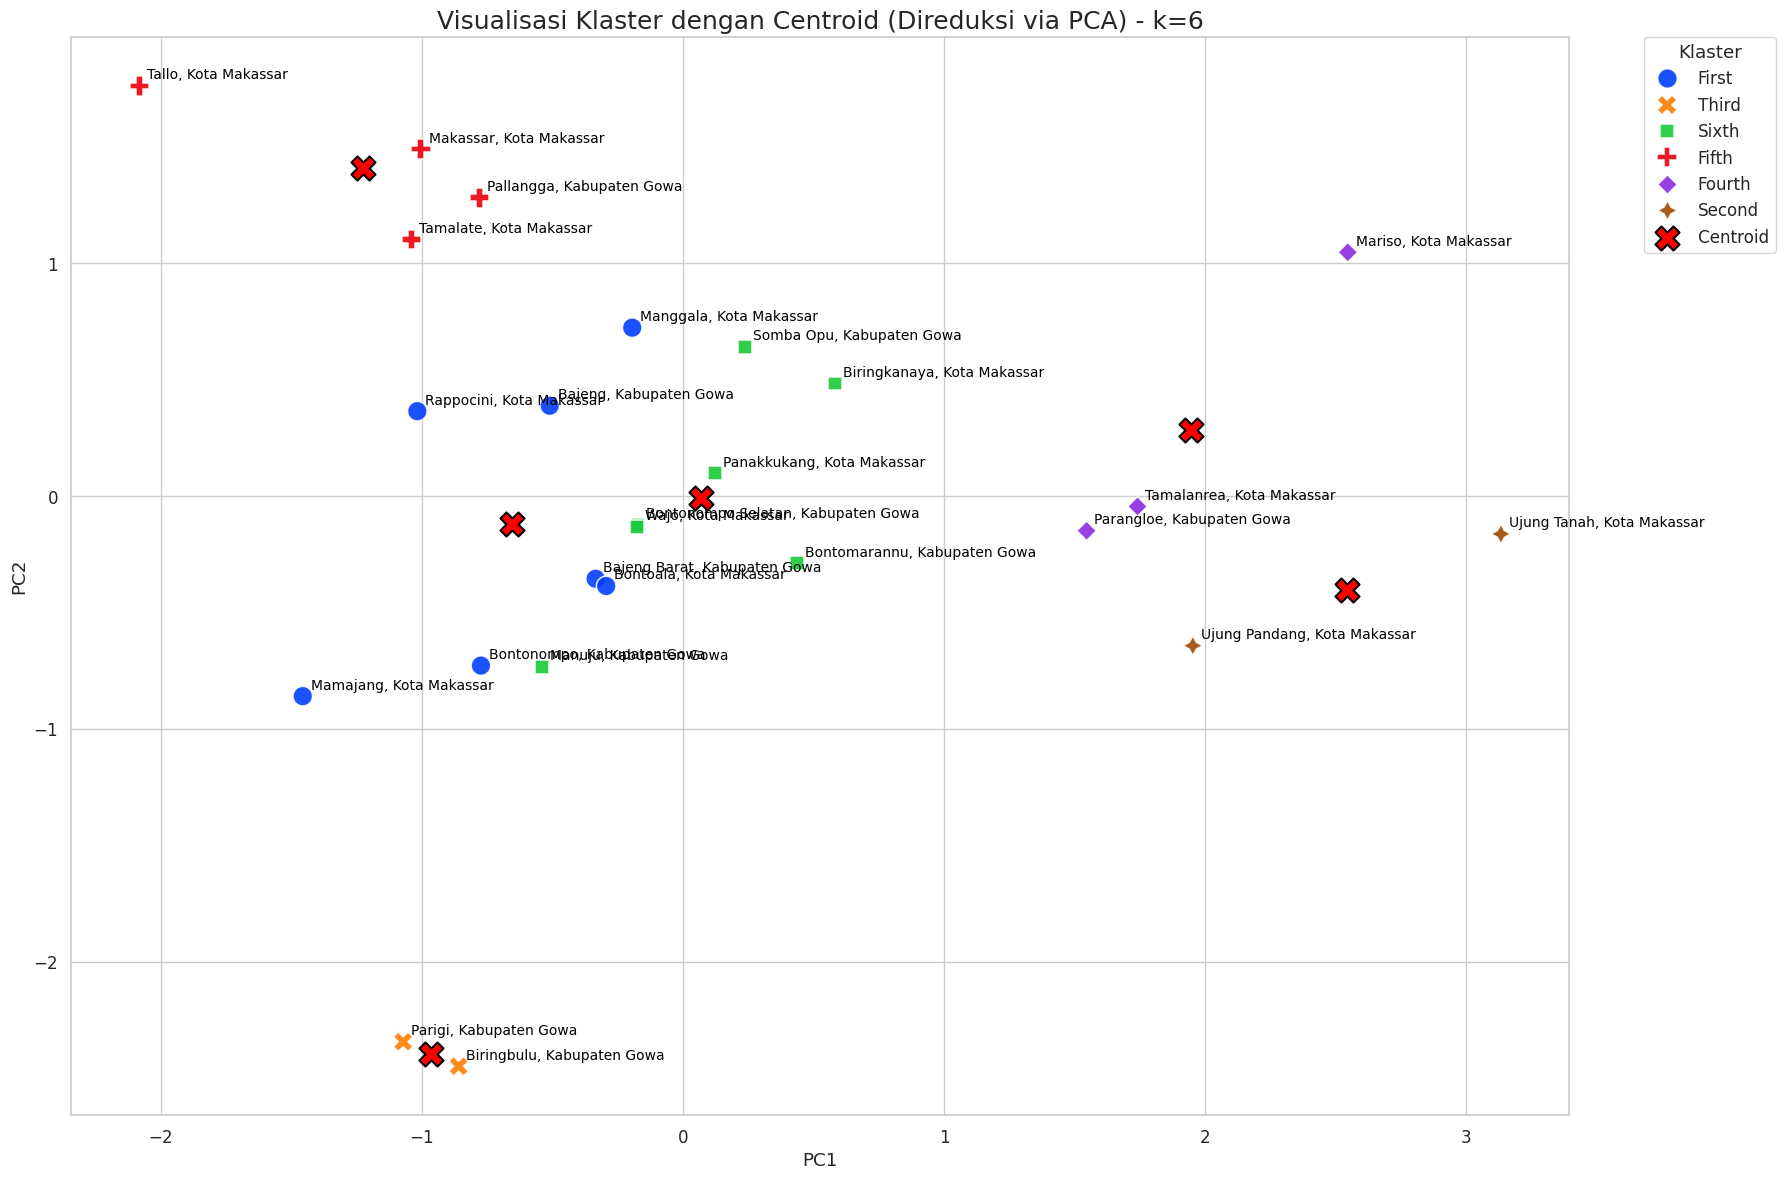

Hasil berhasil disimpan ke:
- result/skenario_6_kmeans_profile.json
- result/skenario_6_kmeans_results.json


In [50]:
results_s6_kmeans, profile_s6_kmeans = run_clustering_pipeline(data=s1_features, n_clusters=6, scenario_name='skenario_6_kmeans', algorithm='kmeans')

**Bisecting K-Means**

In [51]:
# find_optimal_clusters(s2_features, max_k=10, algorithm='bisecting')
# demonstrate_bisecting_kmeans_steps(data=s2_features, n_clusters=6)
# results_s2_bisecting, profile_s2_bisecting = run_clustering_pipeline(data=s1_features, n_clusters=6, scenario_name='skenario_2_bisecting', algorithm='bisecting')

#
============ Clustering Area Based Selesai ============

In [54]:
# from google.colab import files
# import shutil

# shutil.make_archive("result", 'zip', "result")

'/content/result.zip'